In [1]:
# Libraries
import pandas as pd
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
import smtplib
import logging
from email.mime.text import MIMEText

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy import stats

# Utils modules
from utils import *

# Xplotter
from xplotter.insights import *
from xplotter.formatter import format_spines

FETCHING DATA FROM SQL

In [2]:
import os
import psycopg2 as ps
import pymysql
driver = 'mysql+pymysql'
server = '127.0.0.1'
port = '3306'
database = 'sales'
username = 'root'
password = 'K85southcity1'

connection_string = f"{driver}://{username}:{password}@{server}:{port}/{database}"
from sqlalchemy import create_engine
engine = create_engine(connection_string)
query = "SELECT * FROM combined"
df = pd.read_sql(query, engine)
df

ORDERID CHANNELID          ORDERTYPE ORDERSTATUS  \
0       CTLWT07HI04104       WEB  PURCHASEEQUIPMENT   Completed   
1       CTLWT07ND04290       WEB       CHANGEMSISDN   Completed   
2       CTLWT04XX99611       WEB       CHANGEMSISDN   Completed   
3       CTLWT07ZY04671       WEB  PURCHASEEQUIPMENT   Completed   
4       CTLWT087W05034       WEB       CHANGEMSISDN   Completed   
...                ...       ...                ...         ...   
300006  CTLSD00GC90980       WEB  PURCHASEEQUIPMENT   Completed   
300007  CTLSD00W993338       WEB       CHANGEMSISDN   Completed   
300008  CTLSD036W16397       WEB       CHANGEMSISDN   Completed   
300009  CTLSD09PF44071       WEB       CHANGEMSISDN   Completed   
300010  CTLSD0G2176054       IVR  PURCHASEEQUIPMENT   Completed   

                 CREATIONDATE        LASTUPDATEDDATE  
0       03-APR-22 02.44.06 AM  03-APR-22 02.44.28 AM  
1       03-APR-22 02.45.13 AM  03-APR-22 02.45.38 AM  
2       03-APR-22 01.46.45 AM  03-APR-22 01.47.05 AM  
3       03-APR-22 02.53.21 AM  03-APR-22 02.53.45 AM  
4       03-APR-22 02.57.32 AM  03-APR-22 02.57.49 AM  
...                       ...                    ...  
300006  10-SEP-22 12.10.11 AM  10-SEP-22 12.10.16 AM  
300007  10-SEP-22 12.19.21 AM  10-SEP-22 12.23.49 AM  
300008  10-SEP-22 01.08.56 AM  10-SEP-22 01.09.29 AM  
300009  10-SEP-22 03.29.39 AM  10-SEP-22 03.29.52 AM  
300010  10-SEP-22 05.47.03 AM  10-SEP-22 05.47.10 AM  

[300011 rows x 6 columns]

In [3]:
print(f'Orders Dataset shape: {df.shape}')
df.head()

Orders Dataset shape: (300011, 6)


ORDERID CHANNELID          ORDERTYPE ORDERSTATUS  \
0  CTLWT07HI04104       WEB  PURCHASEEQUIPMENT   Completed   
1  CTLWT07ND04290       WEB       CHANGEMSISDN   Completed   
2  CTLWT04XX99611       WEB       CHANGEMSISDN   Completed   
3  CTLWT07ZY04671       WEB  PURCHASEEQUIPMENT   Completed   
4  CTLWT087W05034       WEB       CHANGEMSISDN   Completed   

            CREATIONDATE        LASTUPDATEDDATE  
0  03-APR-22 02.44.06 AM  03-APR-22 02.44.28 AM  
1  03-APR-22 02.45.13 AM  03-APR-22 02.45.38 AM  
2  03-APR-22 01.46.45 AM  03-APR-22 01.47.05 AM  
3  03-APR-22 02.53.21 AM  03-APR-22 02.53.45 AM  
4  03-APR-22 02.57.32 AM  03-APR-22 02.57.49 AM

# EDA 

In [4]:
# Inspect the Orders dataset
print(df.index.is_unique)
print(df.columns.is_unique)
duplicate = df[df.duplicated()]
duplicate

True
True


ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE  \
50001   ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
75002   ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
100003  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
125004  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
150005  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
175006  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
200007  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
225008  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
250009  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   
275010  ORDERID  CHANNELID  ORDERTYPE  ORDERSTATUS  CREATIONDATE   

        LASTUPDATEDDATE  
50001   LASTUPDATEDDATE  
75002   LASTUPDATEDDATE  
100003  LASTUPDATEDDATE  
125004  LASTUPDATEDDATE  
150005  LASTUPDATEDDATE  
175006  LASTUPDATEDDATE  
200007  LASTUPDATEDDATE  
225008  LASTUPDATEDDATE  
250009  LASTUPDATEDDATE  
275010  LASTUPDATEDDATE

In [5]:
# Dropping the duplicate values
df.drop_duplicates(keep=False, inplace=True)

In [6]:
duplicate = df[df.duplicated()]
duplicate

Empty DataFrame
Columns: [ORDERID, CHANNELID, ORDERTYPE, ORDERSTATUS, CREATIONDATE, LASTUPDATEDDATE]
Index: []

The orders data set is ready to use as no duplicated values for rows and columns, all of them are unique.

In [7]:
# Checking for null values
print(df['CHANNELID'].isna())

0         False
1         False
2         False
3         False
4         False
          ...  
300006    False
300007    False
300008    False
300009    False
300010    False
Name: CHANNELID, Length: 300000, dtype: bool


In [8]:

df.isnull().sum()

ORDERID            0
CHANNELID          0
ORDERTYPE          0
ORDERSTATUS        0
CREATIONDATE       0
LASTUPDATEDDATE    0
dtype: int64

As noted as above, there's no missing values for the Orders dataset, we can now move on to the inspection on the dataset. 

In [9]:
from datetime import datetime

def converter(x):
    try:
        return(datetime.strptime(x, "%d-%b-%y %I.%M.%S %p").strftime("%m/%d/%Y %H:%M:%S"))
    except:
        return x
df['CREATIONDATE'] = df['CREATIONDATE'].apply(converter)

In [10]:
df = df.drop(columns=['ORDERID','LASTUPDATEDDATE'])
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [11]:
df

CHANNELID          ORDERTYPE ORDERSTATUS         CREATIONDATE
0            WEB  PURCHASEEQUIPMENT   Completed  04/03/2022 02:44:06
1            WEB       CHANGEMSISDN   Completed  04/03/2022 02:45:13
2            WEB       CHANGEMSISDN   Completed  04/03/2022 01:46:45
3            WEB  PURCHASEEQUIPMENT   Completed  04/03/2022 02:53:21
4            WEB       CHANGEMSISDN   Completed  04/03/2022 02:57:32
...          ...                ...         ...                  ...
300006       WEB  PURCHASEEQUIPMENT   Completed  09/10/2022 00:10:11
300007       WEB       CHANGEMSISDN   Completed  09/10/2022 00:19:21
300008       WEB       CHANGEMSISDN   Completed  09/10/2022 01:08:56
300009       WEB       CHANGEMSISDN   Completed  09/10/2022 03:29:39
300010       IVR  PURCHASEEQUIPMENT   Completed  09/10/2022 05:47:03

[300000 rows x 4 columns]

With the successful transformation of the dataset, we begin our exploratory data analysis.

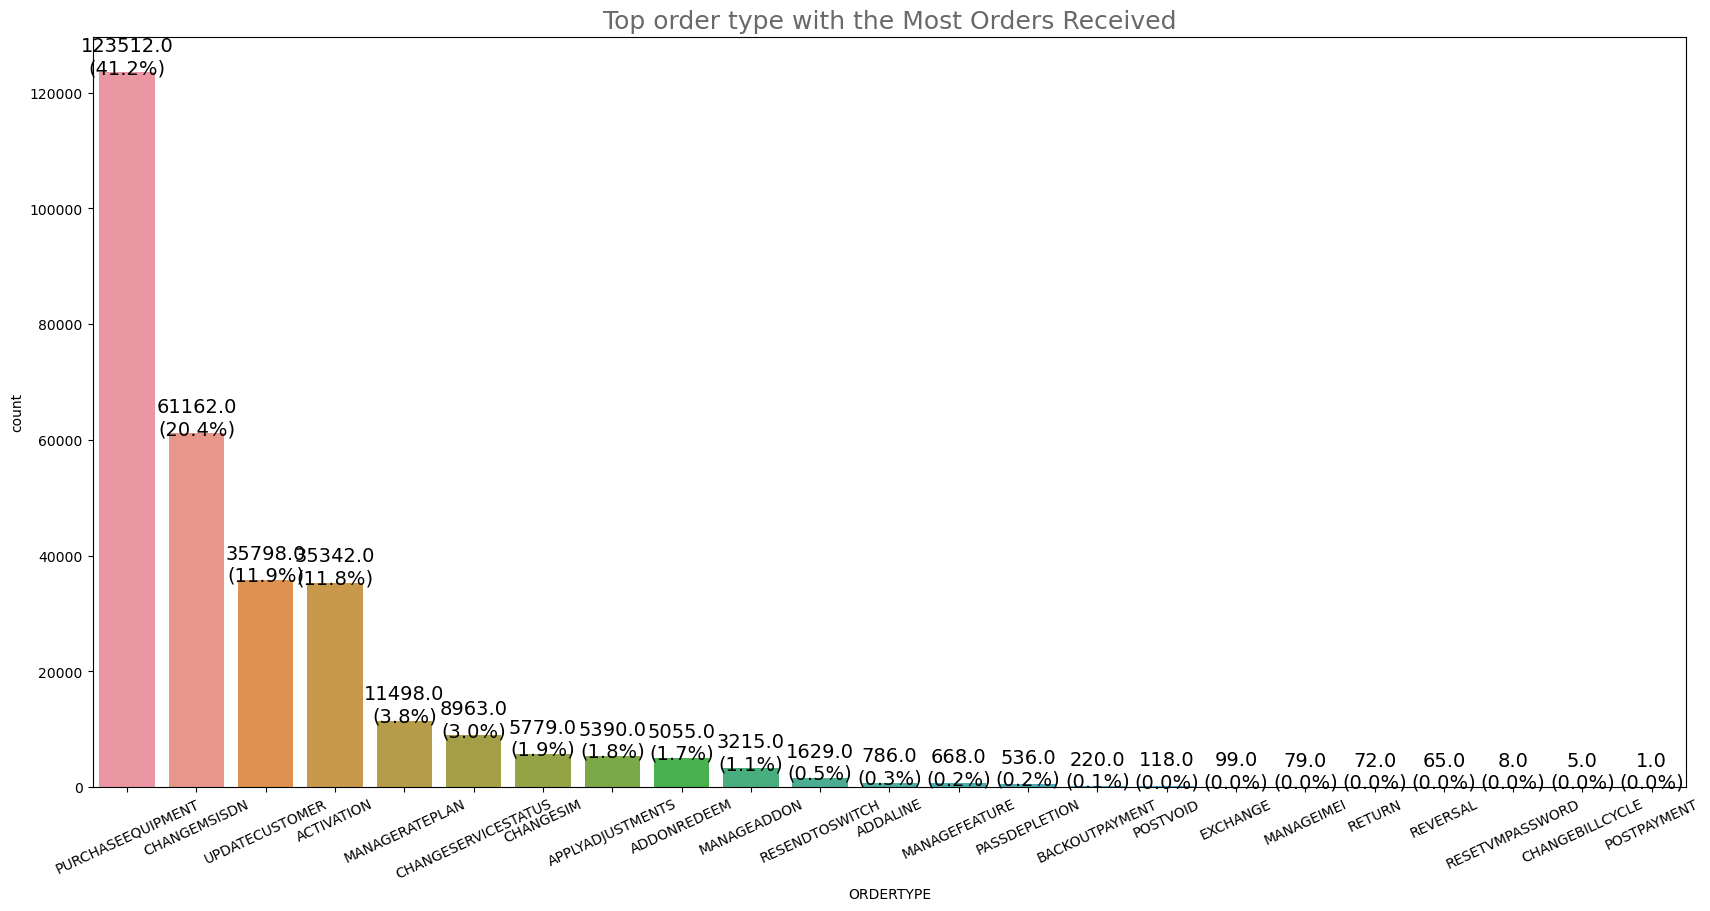

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Assuming you have a DataFrame 'df' and 'top' defined

# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(25, 9))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 1:3])

# Countplot for ORDERTYPE
sns.set_palette("pastel")  # Set a pastel color palette
top=len(df['ORDERTYPE'].value_counts().unique())


order_counts = df['ORDERTYPE'].value_counts()
top_orders = order_counts[:top]

ax1 = sns.countplot(data=df, x='ORDERTYPE', order=top_orders.index, ax=ax1)

ax1.set_title(f'Top order type with the Most Orders Received', color='dimgrey', size=18)

for tick in ax1.get_xticklabels():
    tick.set_rotation(25)

# Annotate each bar with the count and percentage
total_count = len(df['ORDERTYPE'])
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}\n({height/total_count*100:.1f}%)',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=14, color='black', xytext=(0, 11),
                 textcoords='offset points')

plt.show()


From the graph above, we can see that PURCHASEEQUIPMENT is the most received order type, which represents a total of 41.2% of the whole group.

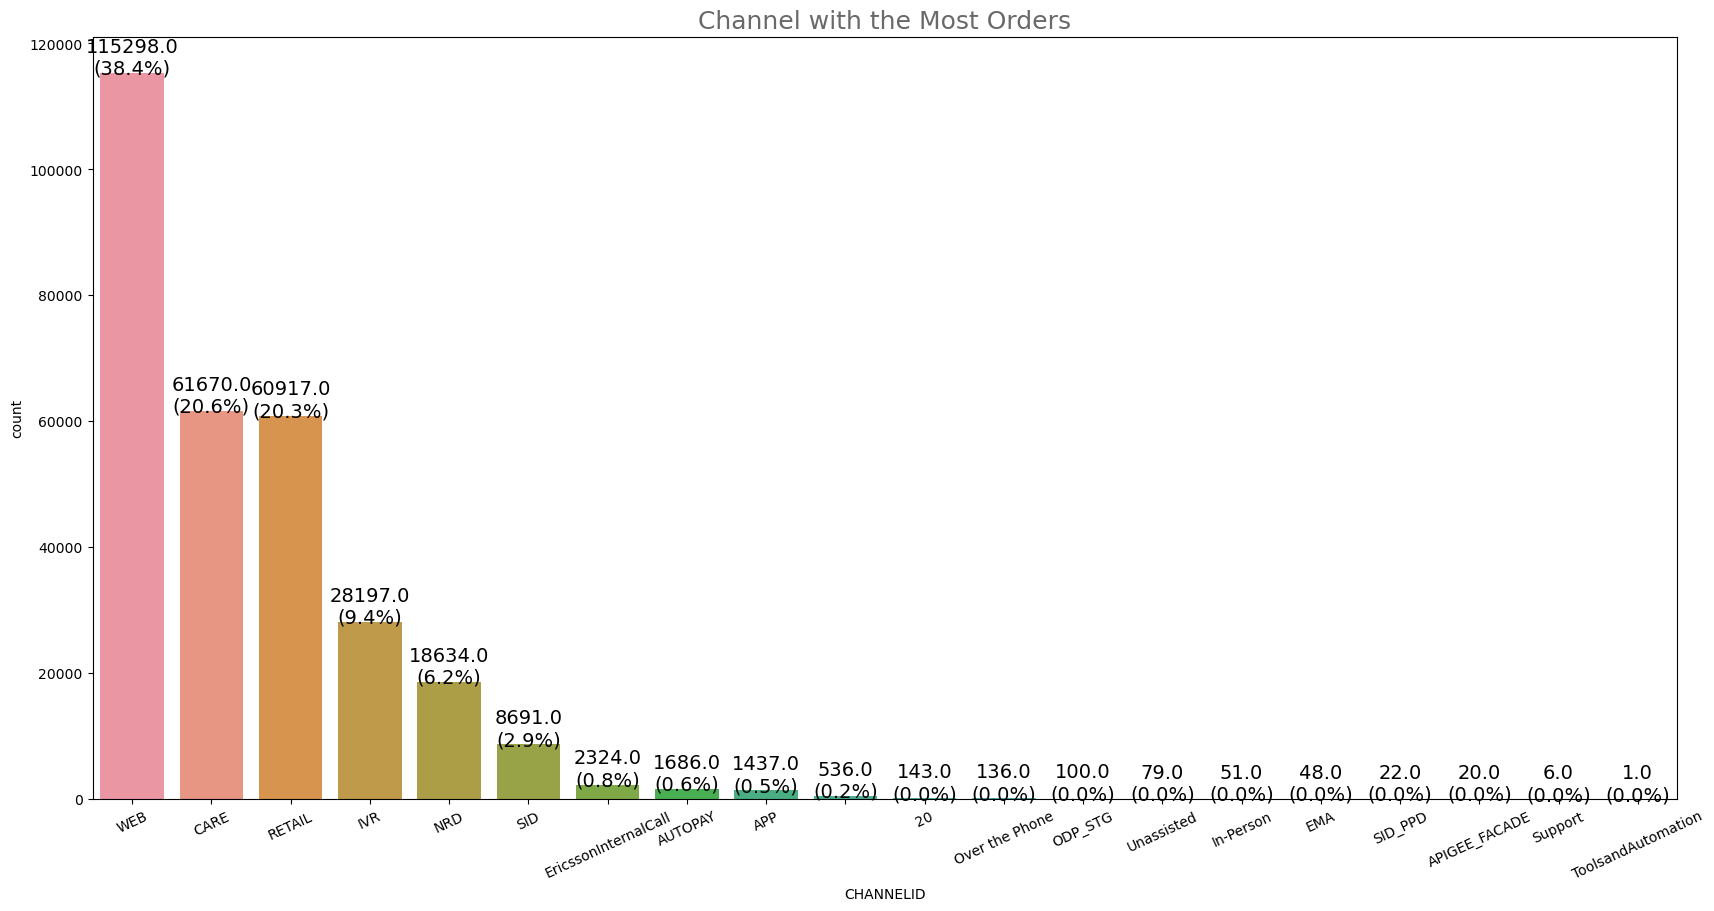

In [13]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(25, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax3 = fig.add_subplot(gs[0, 1:3])

# Axis 3 - Top 20 Customers with the Most Orders
top=len(df['CHANNELID'].value_counts().unique())

sns.countplot(data=df, x='CHANNELID', order=df['CHANNELID'].value_counts().index[:top])

ax3.set_title(f'Channel with the Most Orders', color='dimgrey', size=18)

for tick in ax3.get_xticklabels():
    tick.set_rotation(25)
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(f'{height}\n({height/total_count*100:.1f}%)',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=14, color='black', xytext=(0, 11),
                 textcoords='offset points')

plt.show()


From the graph above, we can see that orders are mostly received through WEB, which represents a total of 38.4% of the whole group. Also we have a CHANNELID with no name.

In [14]:
# Changing the data type for date columns
timestamp_cols = ['CREATIONDATE']
for col in timestamp_cols:
    df[col] = pd.to_datetime(df[col])
    
# Extracting attributes for Order Date - Hour and Time of the Day
df['ORDERDATEHOUR'] = df['CREATIONDATE'].apply(lambda x: x.hour)
hours_bins = [0, 5, 11, 16, 20, 23]
hours_labels = ['Midnight', 'Morning', 'Afternoon', 'Evening', 'Night']
df['ORDERDATEHOURDAY'] = pd.cut(df['ORDERDATEHOUR'], hours_bins, labels=hours_labels,include_lowest=True)

# New DataFrame after transformations
df

CHANNELID          ORDERTYPE ORDERSTATUS        CREATIONDATE  \
0            WEB  PURCHASEEQUIPMENT   Completed 2022-04-03 02:44:06   
1            WEB       CHANGEMSISDN   Completed 2022-04-03 02:45:13   
2            WEB       CHANGEMSISDN   Completed 2022-04-03 01:46:45   
3            WEB  PURCHASEEQUIPMENT   Completed 2022-04-03 02:53:21   
4            WEB       CHANGEMSISDN   Completed 2022-04-03 02:57:32   
...          ...                ...         ...                 ...   
300006       WEB  PURCHASEEQUIPMENT   Completed 2022-09-10 00:10:11   
300007       WEB       CHANGEMSISDN   Completed 2022-09-10 00:19:21   
300008       WEB       CHANGEMSISDN   Completed 2022-09-10 01:08:56   
300009       WEB       CHANGEMSISDN   Completed 2022-09-10 03:29:39   
300010       IVR  PURCHASEEQUIPMENT   Completed 2022-09-10 05:47:03   

        ORDERDATEHOUR ORDERDATEHOURDAY  
0                   2         Midnight  
1                   2         Midnight  
2                   1         Midnight  
3                   2         Midnight  
4                   2         Midnight  
...               ...              ...  
300006              0         Midnight  
300007              0         Midnight  
300008              1         Midnight  
300009              3         Midnight  
300010              5         Midnight  

[300000 rows x 6 columns]

We are adding two new columns which represents the time interval during which an order was placed.

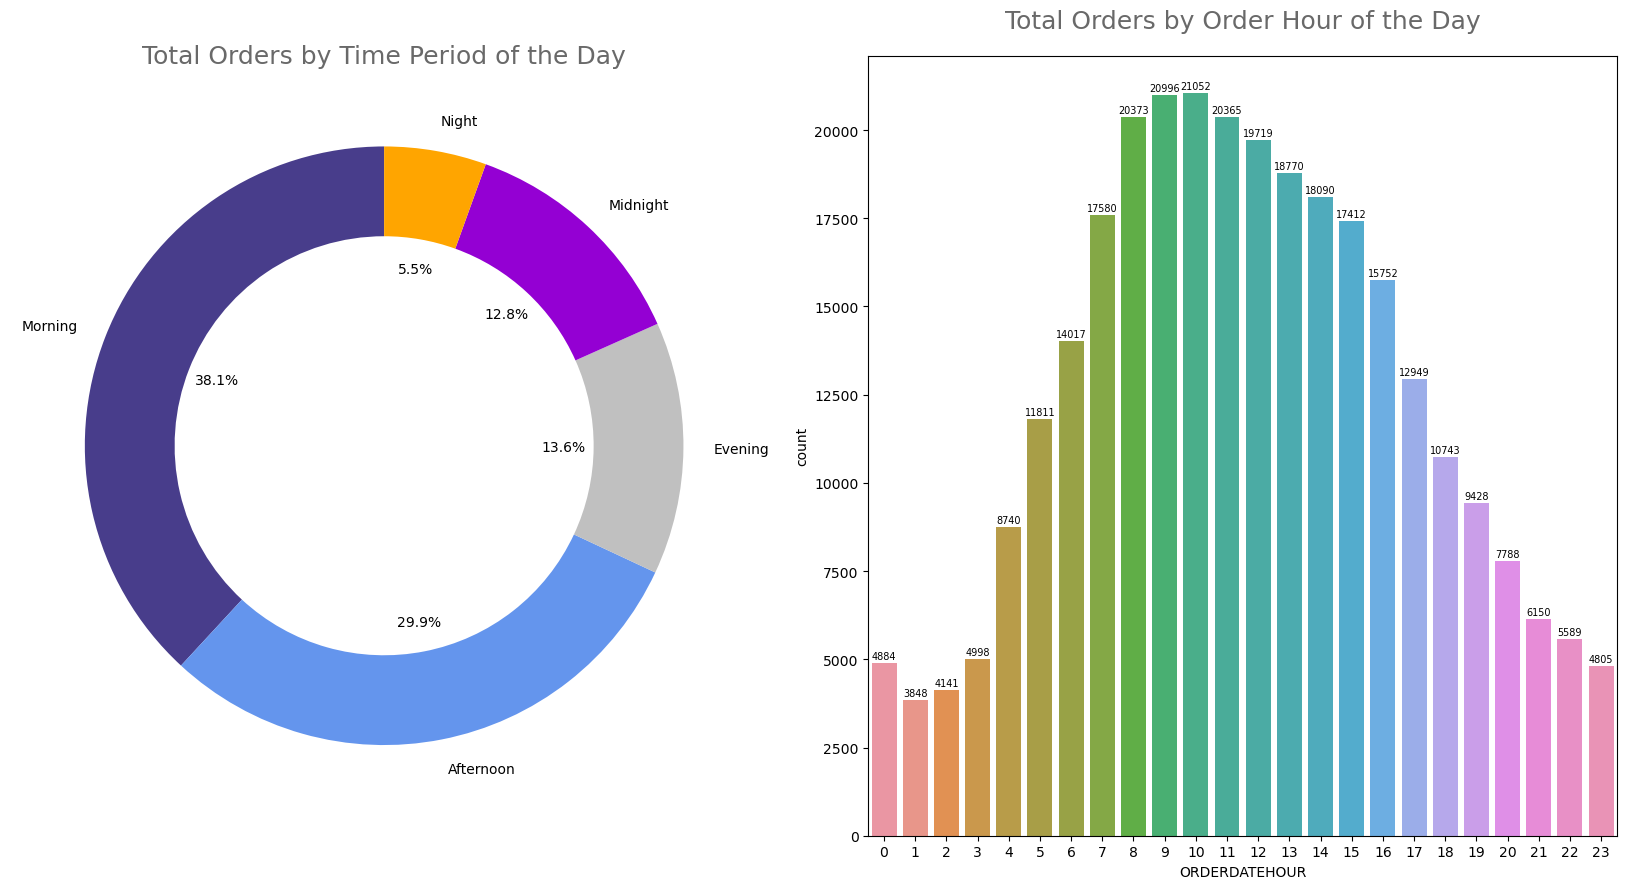

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(25, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax4 = fig.add_subplot(gs[0, 0])
ax5 = fig.add_subplot(gs[0, 1:2])

# Axis 4 - Total Orders by Time Period of the Day
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'orange']
label_names = df['ORDERDATEHOURDAY'].value_counts().index

# Calculate the total counts for each category 
data = df['ORDERDATEHOURDAY'].value_counts()
data = data.reindex(label_names, fill_value=0)  # Ensure all categories are present
ax4.pie(data, labels=label_names, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
ax4.add_artist(plt.Circle((0, 0), 0.6, color='white'))  # Add a white circle for the "donut" effect
ax4.set_title(f'Total Orders by Time Period of the Day', color='dimgrey', size=18)

# Barchart Axis 5 - Total Orders by Order Hour of the day
sns.countplot(df, x='ORDERDATEHOUR', ax=ax5, order=range(24))
ax5.set_title('Total Orders by Order Hour of the Day', size=18, color='dimgrey', pad=20)
for p in ax5.patches:
    ax5.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                    va = 'center',fontsize=7, color='black', xytext = (0, 5),
                 textcoords = 'offset points')

plt.tight_layout()
plt.show()


From the graphs above, we can see that customers often order during Morning and Afternoon period mainly between 8AM and 1PM in a day.

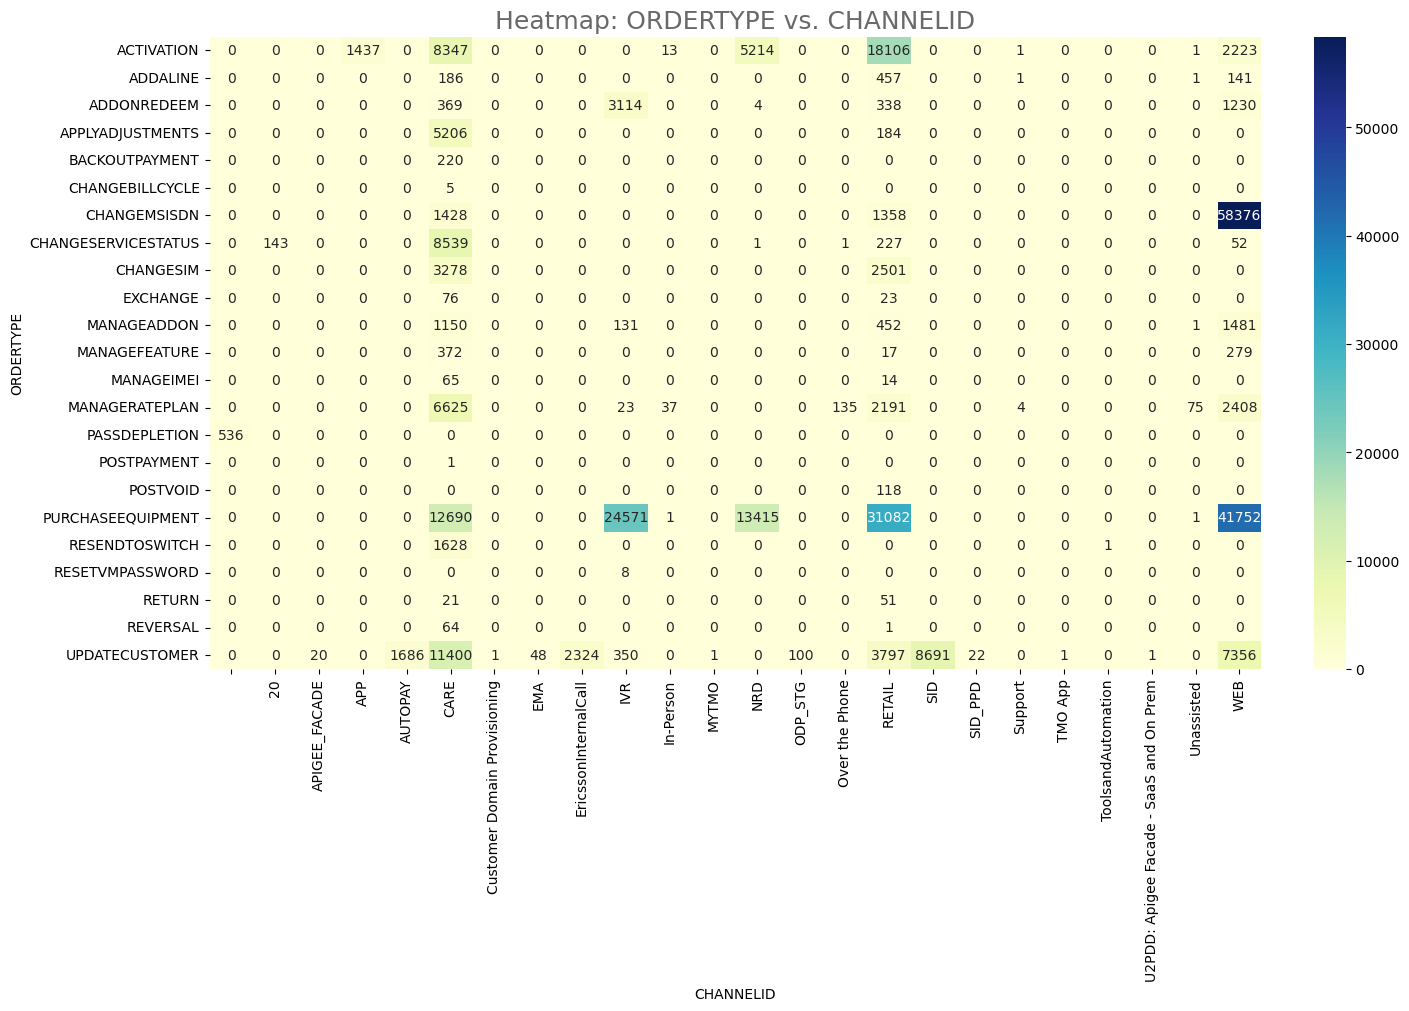

In [16]:
# Create a DataFrame for the cross-tabulation of ORDERTYPE and CHANNELID
cross_tab = pd.crosstab(df['ORDERTYPE'], df['CHANNELID'])

# Build a figure for the heatmap
fig_heatmap = plt.figure(constrained_layout=True, figsize=(14, 10))

# Define a new GridSpec for the heatmap
gs_heatmap = GridSpec(1, 1, figure=fig_heatmap)
ax_heatmap = fig_heatmap.add_subplot(gs_heatmap[0, 0])

# Create a heatmap using Seaborn
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', ax=ax_heatmap)

ax_heatmap.set_title('Heatmap: ORDERTYPE vs. CHANNELID', color='dimgrey', size=18)

plt.show()

This heat map mainly tells us which ORDERTYPE is placed through which CHANNELID. Notable finding is that CARE has more number of ORDERTYPE than WEB with some specific ORDERTYPE being received only through it.

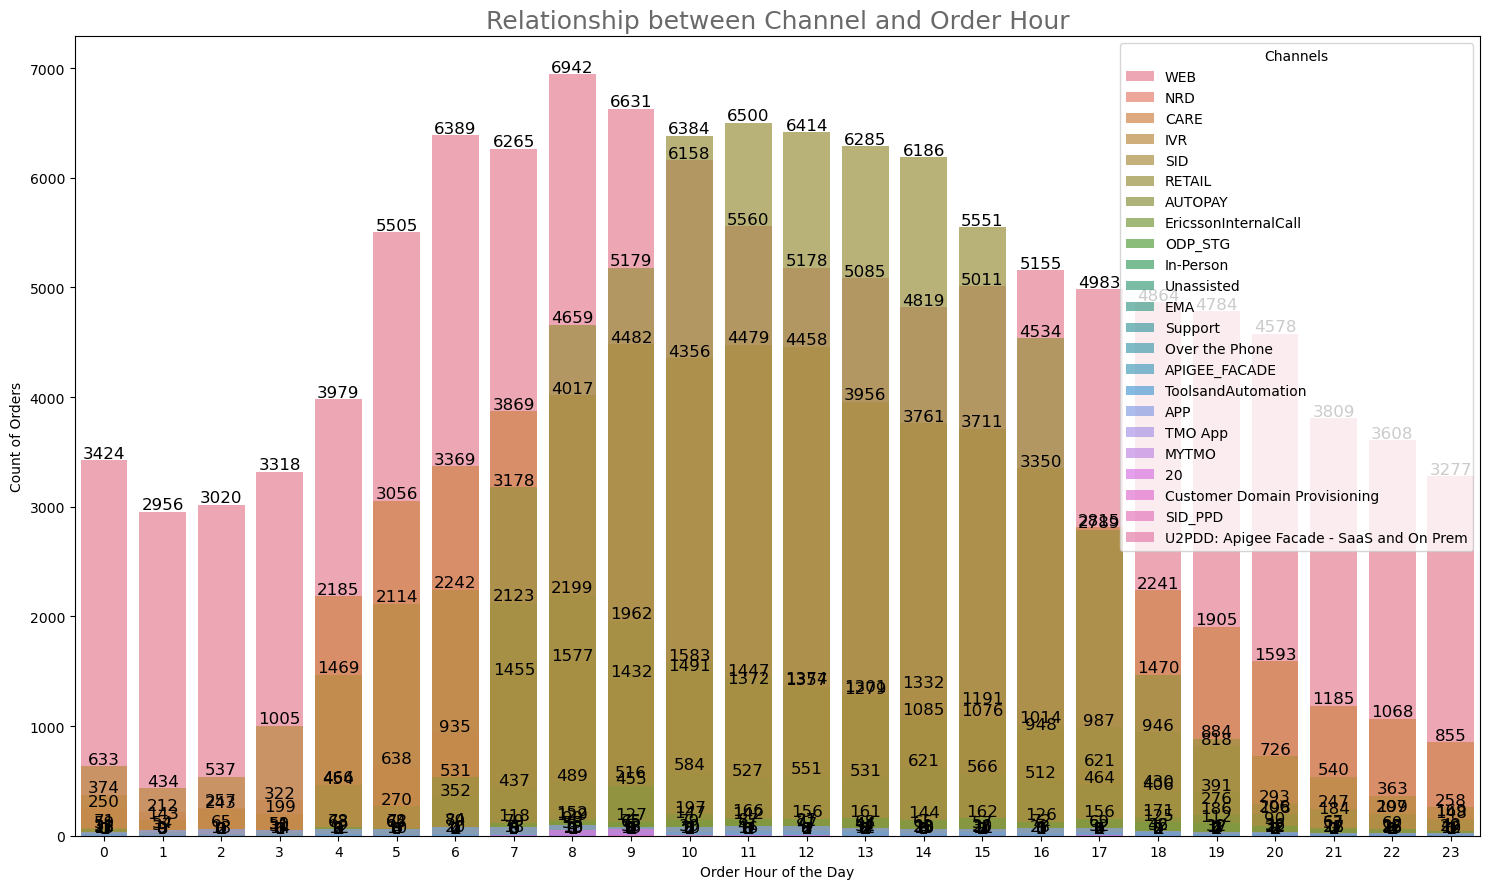

In [17]:
# Assuming you already have ax3 and ax5 defined as in your code
import plotly.express as px

# Create a new figure for the relationship
fig_relation = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs_relation = GridSpec(1, 1, figure=fig_relation)
ax_relation = fig_relation.add_subplot(gs_relation[0, 0])

# Create a relationship between "Channel with the Most Orders" and "Total Orders by Order Hour of the Day"
# Loop through the unique channels and create a bar chart for each channel
channels = df['CHANNELID'].unique()
colors = sns.color_palette("husl", len(channels))

for i, channel in enumerate(channels):
    channel_data = df[df['CHANNELID'] == channel]
    sns.countplot(data=channel_data, x='ORDERDATEHOUR', ax=ax_relation, order=range(24), color=colors[i], alpha=0.7,
                  label=f'{channel}')
    
# Set labels and titles
ax_relation.set_xlabel('Order Hour of the Day')
ax_relation.set_ylabel('Count of Orders')
ax_relation.set_title('Relationship between Channel and Order Hour', size=18, color='dimgrey')

# Add a legend
ax_relation.legend(title='Channels', loc='upper right')
for p in ax_relation.patches:
    ax_relation.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                    va = 'center',fontsize=12, color='black', xytext = (0, 5),
                 textcoords = 'offset points')

plt.tight_layout()
plt.show()


This graph tells that RETAIL orders are placed more than WEB orders between 10AM and 3PM. WEB orders lead in the remaining time throughout the day.

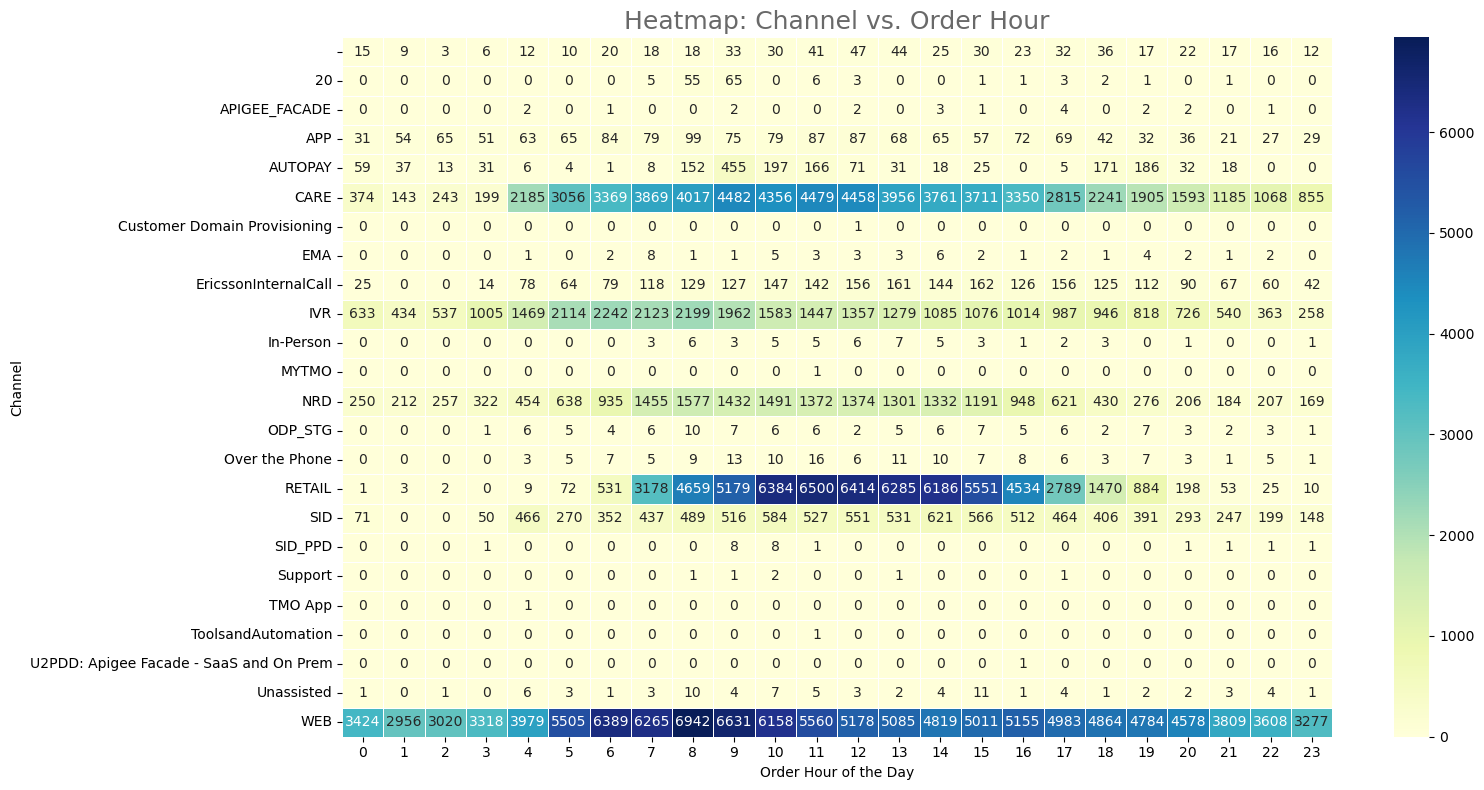

In [18]:
# Calculate the counts for each combination of channel and order hour
heatmap_data = df.groupby(['CHANNELID', 'ORDERDATEHOUR']).size().unstack(fill_value=0)

# Create a figure and axis for the heatmap
plt.figure(figsize=(16, 8))
ax_heatmap = sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)

# Set labels and title
ax_heatmap.set_xlabel('Order Hour of the Day')
ax_heatmap.set_ylabel('Channel')
ax_heatmap.set_title('Heatmap: Channel vs. Order Hour', size=18, color='dimgrey')

plt.tight_layout()
plt.show()

This heat map gives a better visualisation of the above graph. It tells that CARE and IVR orders start receiving earlier that RETAIL orders in the morning.

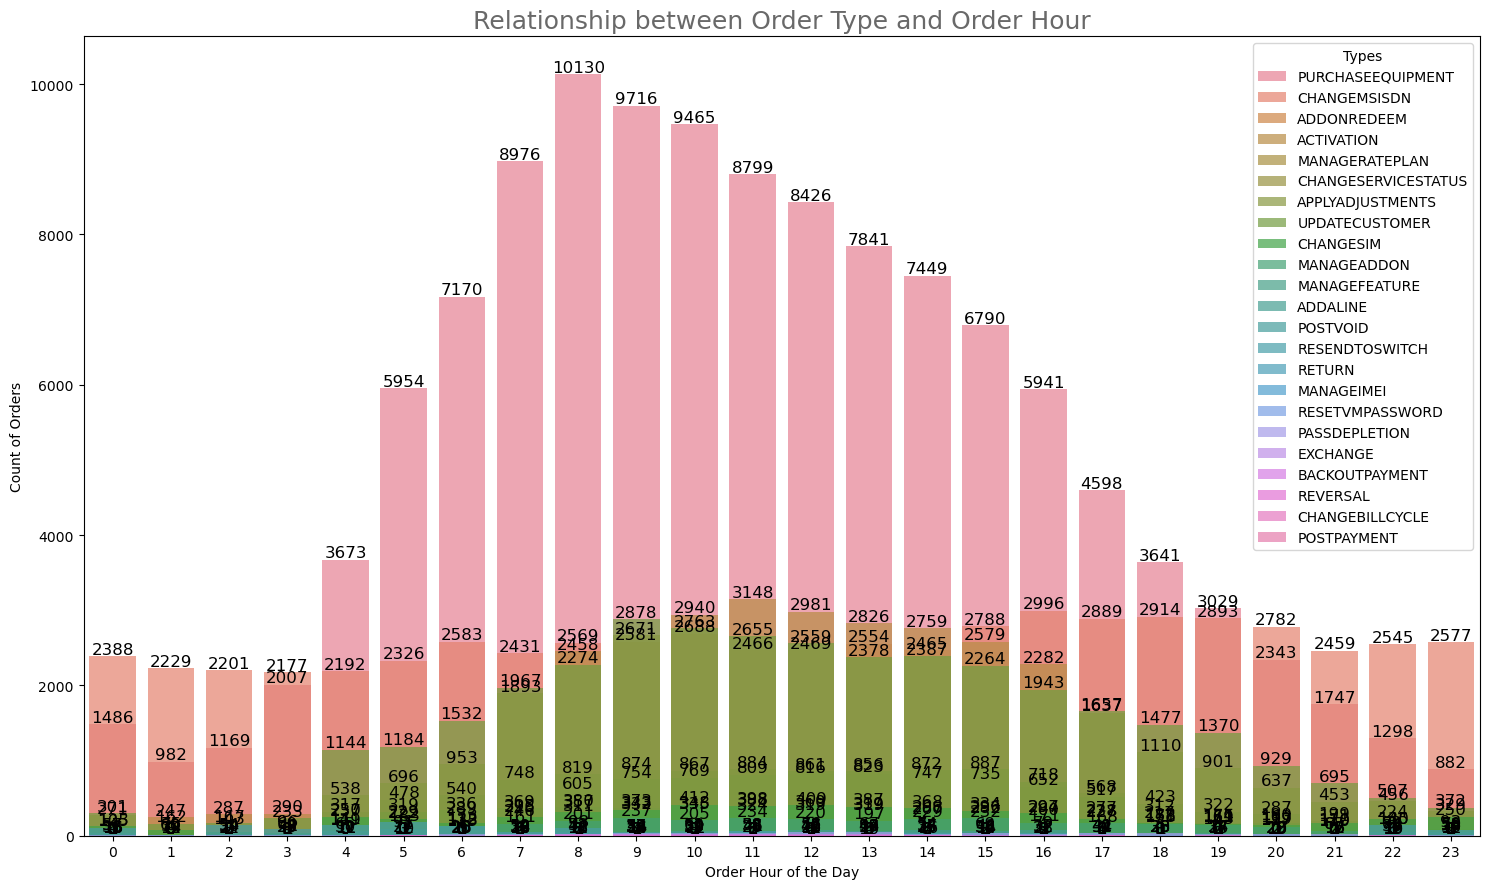

In [19]:
# Assuming you already have ax3 and ax5 defined as in your code

# Create a new figure for the relationship
fig_relation = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs_relation = GridSpec(1, 1, figure=fig_relation)
ax_relation = fig_relation.add_subplot(gs_relation[0, 0])

# Create a relationship between "Channel with the Most Orders" and "Total Orders by Order Hour of the Day"
# Loop through the unique channels and create a bar chart for each channel
types = df['ORDERTYPE'].unique()
colors = sns.color_palette("husl", len(types))

for i, type in enumerate(types):
    type_data = df[df['ORDERTYPE'] == type]
    sns.countplot(data=type_data, x='ORDERDATEHOUR', ax=ax_relation, order=range(24), color=colors[i], alpha=0.7,
                  label=f'{type}')
    
# Set labels and titles
ax_relation.set_xlabel('Order Hour of the Day')
ax_relation.set_ylabel('Count of Orders')
ax_relation.set_title('Relationship between Order Type and Order Hour', size=18, color='dimgrey')
ax_relation.legend(title='Channels', loc='upper right')
ax_relation.legend(title='Channels', loc='upper right')
for p in ax_relation.patches:
    ax_relation.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                    va = 'center',fontsize=12, color='black', xytext = (0, 5),
                 textcoords = 'offset points')
# Add a legend
ax_relation.legend(title='Types', loc='upper right')

plt.tight_layout()
plt.show()


This graph tells that PURCHASEEQUIPMENT are recevind mostly during morning, afternoon and evening while CHANGEMSISDN is received almost equally throughout all time intervals. UPDATECUSTOMER starts in morning and lasts till evening.

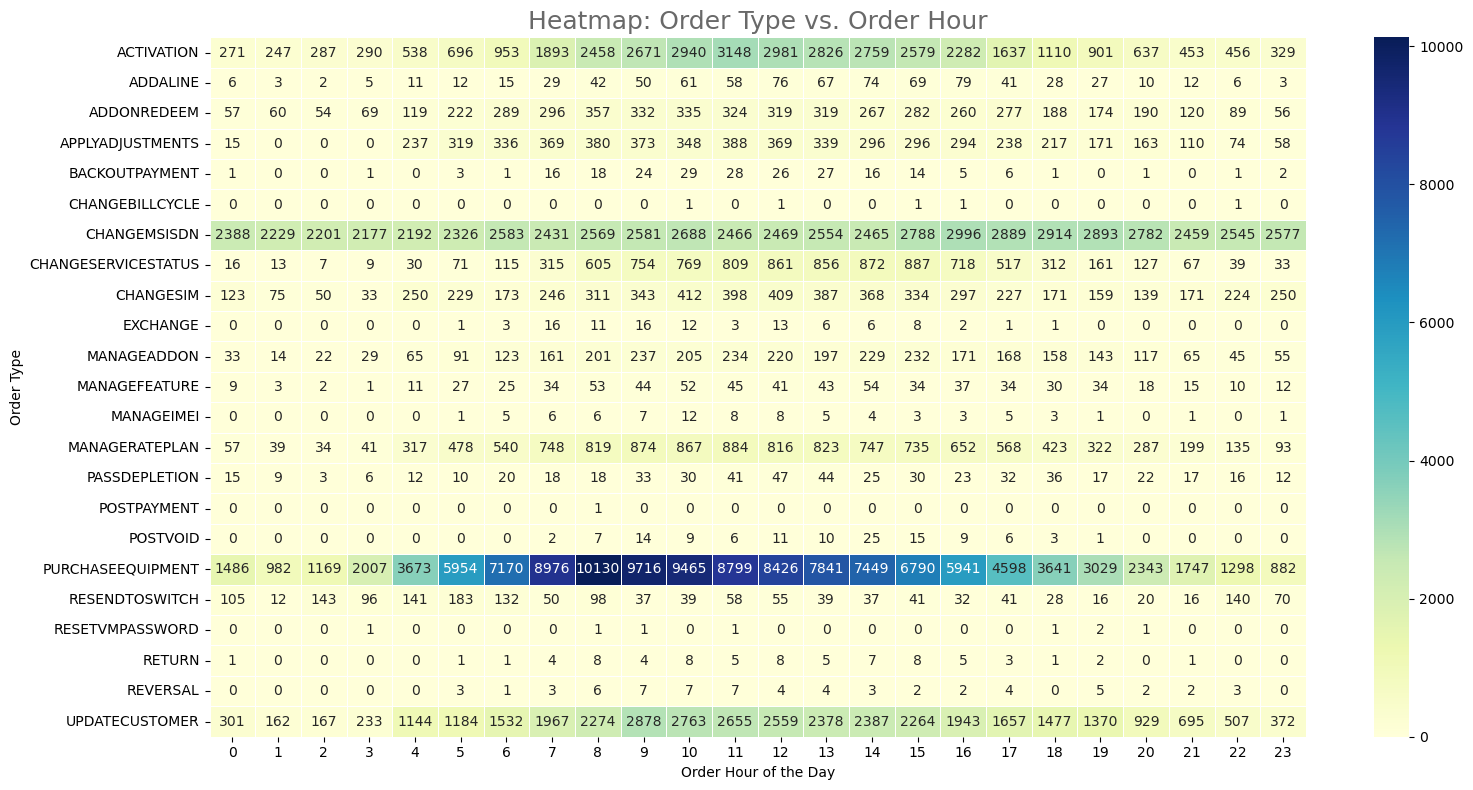

In [20]:
# Calculate the counts for each combination of order type and order hour
heatmap_data = df.groupby(['ORDERTYPE', 'ORDERDATEHOUR']).size().unstack(fill_value=0)

# Create a figure and axis for the heatmap
plt.figure(figsize=(16, 8))
ax_heatmap = sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)

# Set labels and title
ax_heatmap.set_xlabel('Order Hour of the Day')
ax_heatmap.set_ylabel('Order Type')
ax_heatmap.set_title('Heatmap: Order Type vs. Order Hour', size=18, color='dimgrey')

plt.tight_layout()
plt.show()

In [21]:
df['Date'] = df['CREATIONDATE'].dt.date
df['Hour'] = df['CREATIONDATE'].dt.hour
hourly_counts = df.groupby(['Date', 'Hour','ORDERTYPE']).size().reset_index(name='Count')
hourly_counts

Date  Hour          ORDERTYPE  Count
0      2022-01-01     0       CHANGEMSISDN     10
1      2022-01-01     0     MANAGERATEPLAN      1
2      2022-01-01     0  PURCHASEEQUIPMENT     12
3      2022-01-01     0     RESENDTOSWITCH      1
4      2022-01-01     0     UPDATECUSTOMER      2
...           ...   ...                ...    ...
28290  2022-12-09    23     UPDATECUSTOMER      1
28291  2022-12-10     0         ACTIVATION      1
28292  2022-12-10     0       CHANGEMSISDN      3
28293  2022-12-10     0  PURCHASEEQUIPMENT      1
28294  2022-12-30     7       CHANGEMSISDN      1

[28295 rows x 4 columns]

In [22]:

#hourly_counts['Count'] = np.log(hourly_counts['Count'] + 1.5)

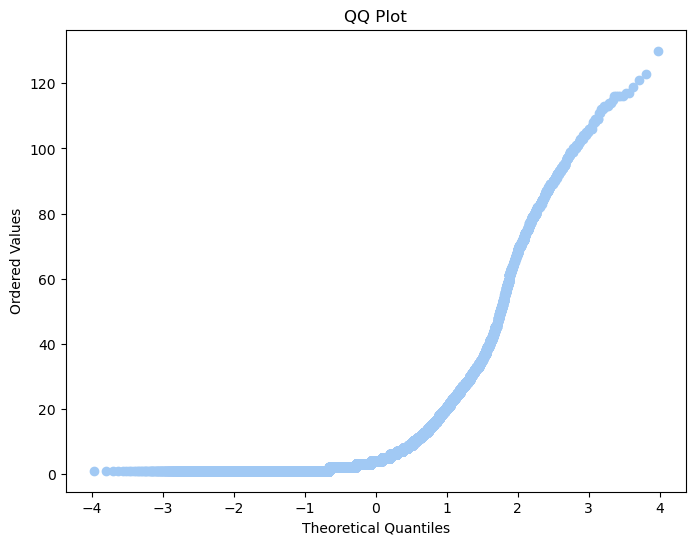

In [23]:

# Generate theoretical quantiles for a normal distribution
theoretical_quantiles = np.linspace(0, 1, len(hourly_counts))
theoretical_values = stats.norm.ppf(theoretical_quantiles)

# Sort the observed values
sorted_observed_values = np.sort(hourly_counts['Count'])

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(theoretical_values, sorted_observed_values)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('QQ Plot')
plt.show()


In [24]:
# plot that exhibit this behavior usually mean that our  data has more extreme values than would be expected if they truly came from a normal distribution.

<Figure size 1200x600 with 0 Axes>

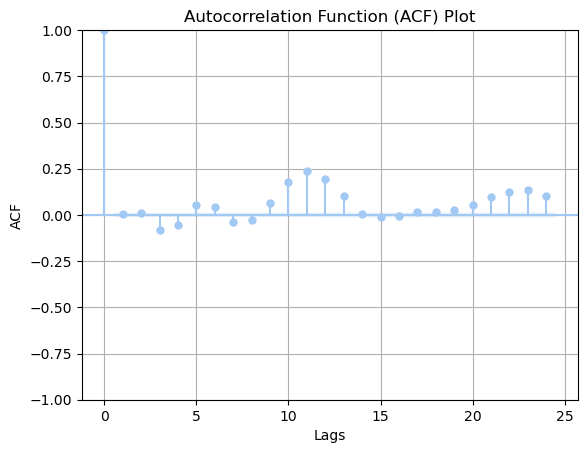

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(hourly_counts['Count'], lags=24) 
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid()
plt.show()

<Figure size 1000x400 with 0 Axes>

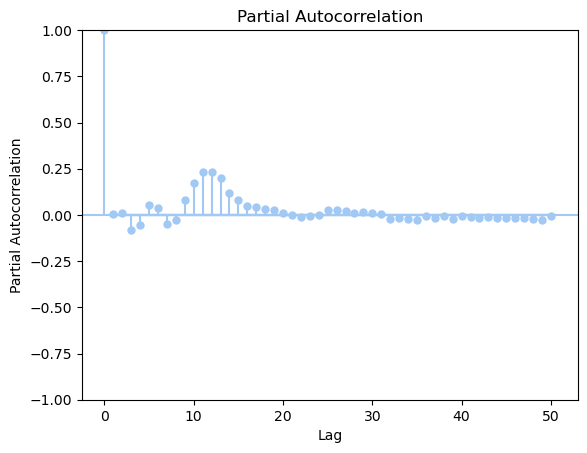

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

# Create a PACF plot
plt.figure(figsize=(10, 4))
plot_pacf(hourly_counts['Count'], lags=50)  
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [27]:
df['Date'] = pd.to_datetime(df['Date'])

# MODEL TRAINING

In [28]:
train.shape, test.shape

((240000, 4), (60000, 4))

In [29]:
train.nunique()

CHANNELID           22
ORDERTYPE           23
ORDERSTATUS          7
CREATIONDATE    236318
dtype: int64

# ARIMA INPLEMENTATION

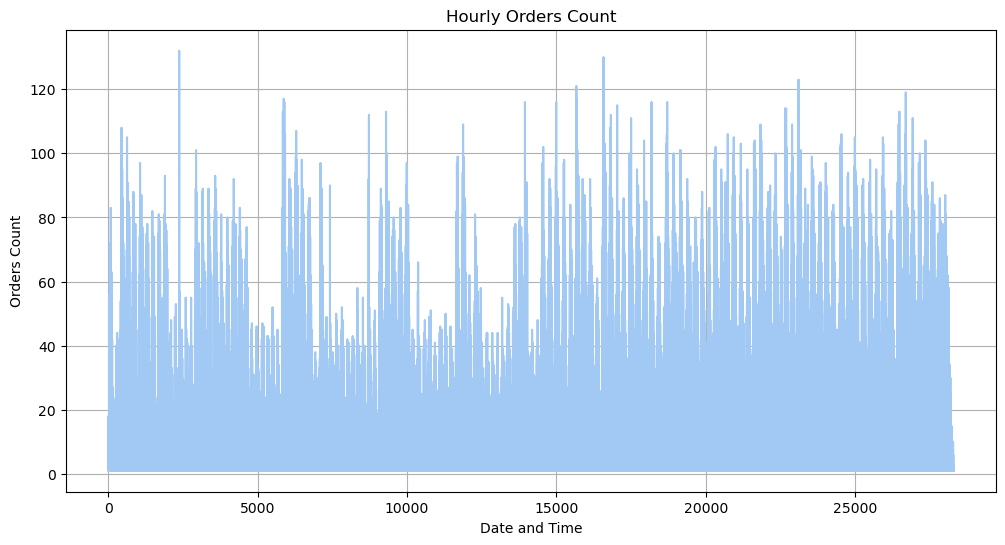

In [30]:
# Plot the orders count data
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts['Count'])
plt.title('Hourly Orders Count')
plt.xlabel('Date and Time')
plt.ylabel('Orders Count')
plt.grid()
plt.show()


In [31]:
#arima
hourly_counts['Count_diff'] = hourly_counts['Count'].diff()

In [32]:
train_size = int(len(hourly_counts) * 0.8)
train_data = hourly_counts.iloc[:train_size]
test_data = hourly_counts.iloc[train_size:]

In [33]:

p, d, q = 1, 1, 1  # Example values; adjust based on your data

# Create and fit the ARIMA model
model = sm.tsa.arima.ARIMA(train_data['Count_diff'], order=(p, d, q))
results = model.fit()

In [34]:
forecast = results.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean


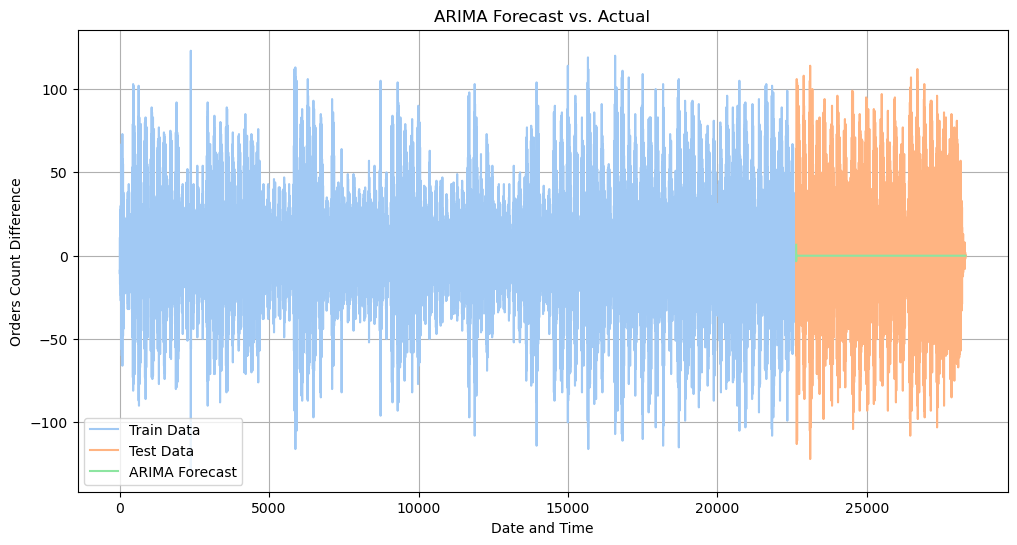

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Count_diff'], label='Train Data')
plt.plot(test_data.index, test_data['Count_diff'], label='Test Data')
plt.plot(test_data.index, forecast_mean, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs. Actual')
plt.xlabel('Date and Time')
plt.ylabel('Orders Count Difference')
plt.legend()
plt.grid()
plt.show()


# SARIMA IMPLEMENTATION

# REGRESSION MODEL

In [36]:
train_size = int(0.8 * len(hourly_counts))
train_data = hourly_counts.iloc[:train_size]
test_data = hourly_counts.iloc[train_size:]

In [37]:
forecast_diff = results.get_forecast(steps=len(hourly_counts))
forecast_mean_diff = forecast_diff.predicted_mean
forecast_mean = hourly_counts['Count'].iloc[train_size - 1] + forecast_mean_diff.cumsum()

In [38]:
mae = mean_absolute_error(hourly_counts['Count'], forecast_mean)
rmse = np.sqrt(mean_squared_error(hourly_counts['Count'], forecast_mean))
mape = np.mean(np.abs((hourly_counts['Count'] - forecast_mean) / hourly_counts['Count'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 19.09
RMSE: 26.68
MAPE: 106.09%


In [39]:
threshold = 15.0  # Adjust this threshold based on your data and requirements

if mape > threshold:
    alert_message = f"Deviation detected: MAPE = {mape:.2f}% (Threshold = {threshold:.2f}%)"
    print(alert_message)


Deviation detected: MAPE = 106.09% (Threshold = 15.00%)


# SMA IMPLEMENTATION

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'hourly_counts' with 'Hour', 'OrderType', and 'Count' columns
window_size = 24
hourly_counts['sma'] = hourly_counts.groupby(['Hour', 'ORDERTYPE'])['Count'].transform(lambda x: x.rolling(window=window_size).mean())
hourly_counts['Percentage_change'] = ((hourly_counts['Count'] - hourly_counts['sma']) / hourly_counts['sma']).abs()


In [41]:
# Calculate mean and standard deviation of percentage changes for each unique combination
grouped = hourly_counts.groupby(['Hour', 'ORDERTYPE'])['Percentage_change']
mean_percentage_change = grouped.transform('mean')
std_dev_percentage_change = grouped.transform('std')

In [42]:
# Set the threshold for each combination 
threshold = 5 * std_dev_percentage_change

In [43]:
# Check if the percentage change exceeds the threshold for each combination
hourly_counts['Alert'] = hourly_counts['Percentage_change'] > threshold

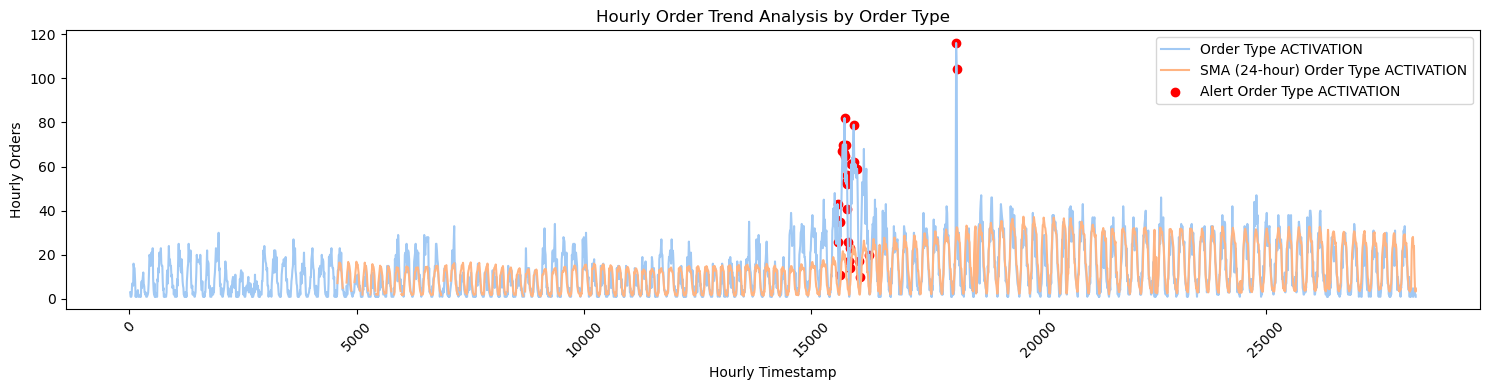

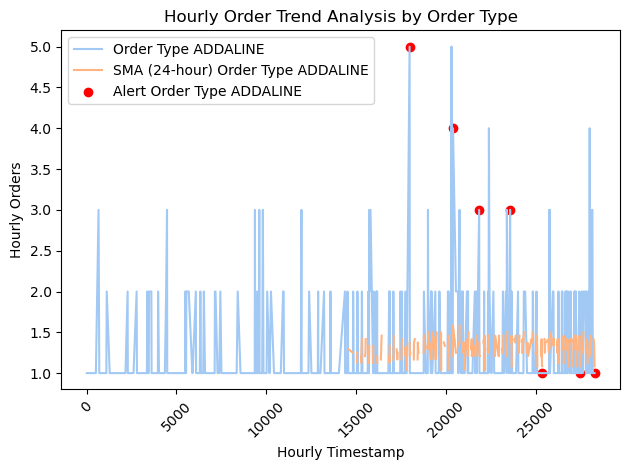

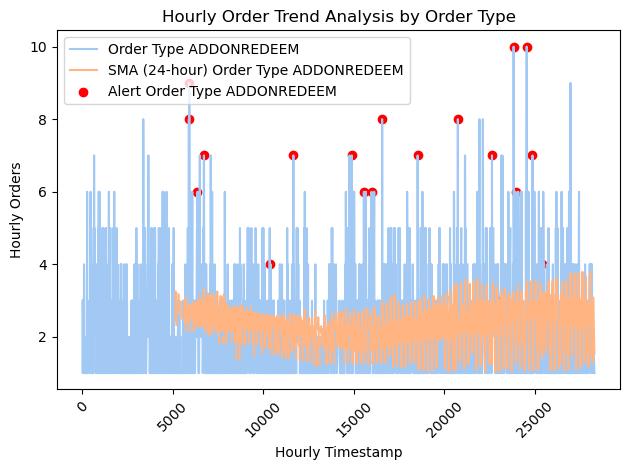

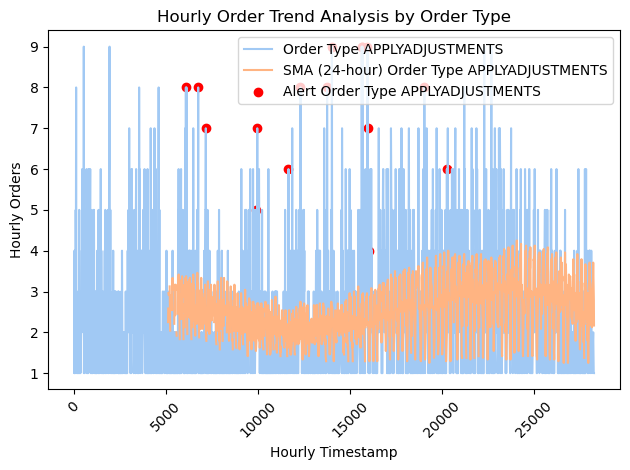

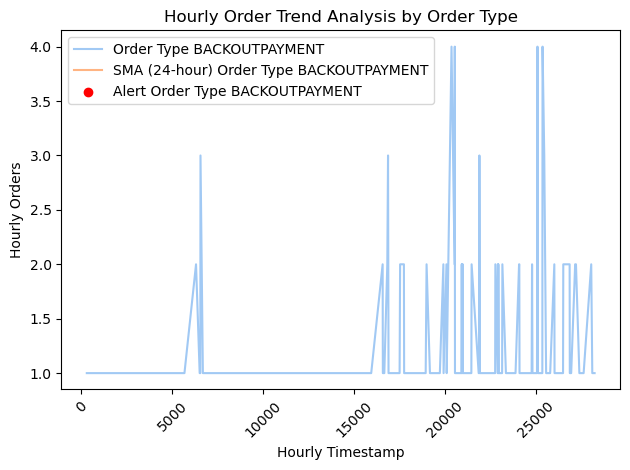

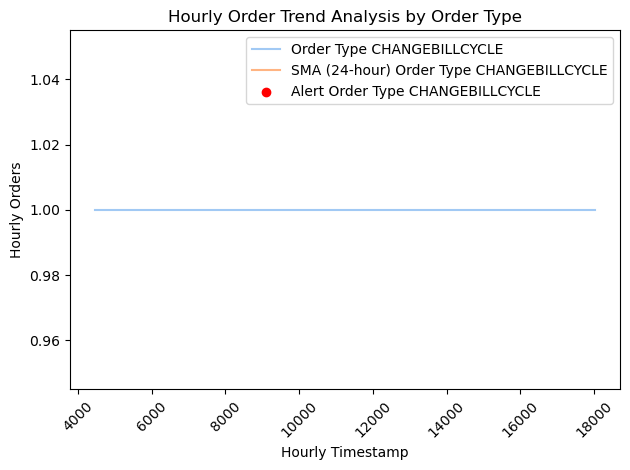

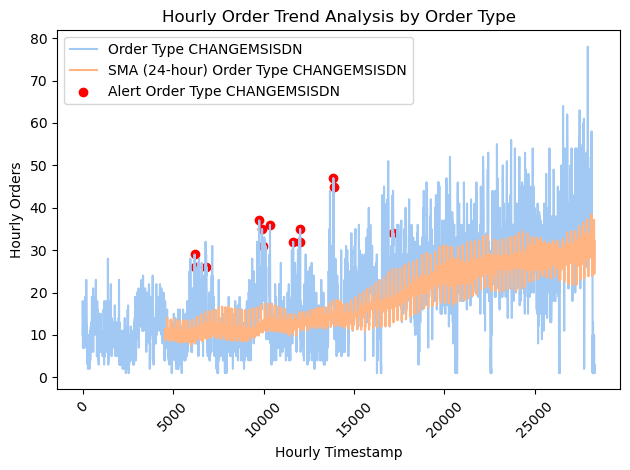

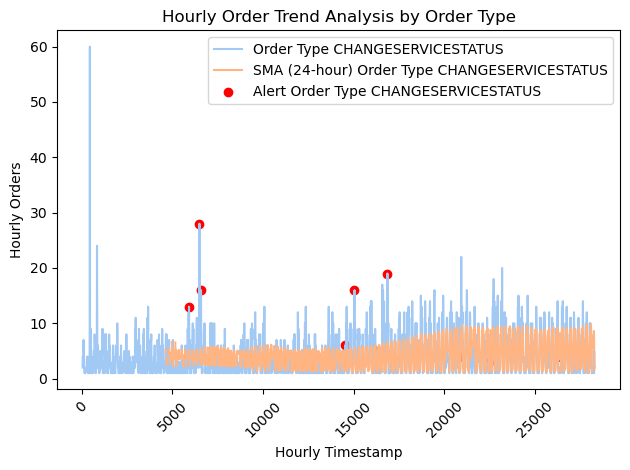

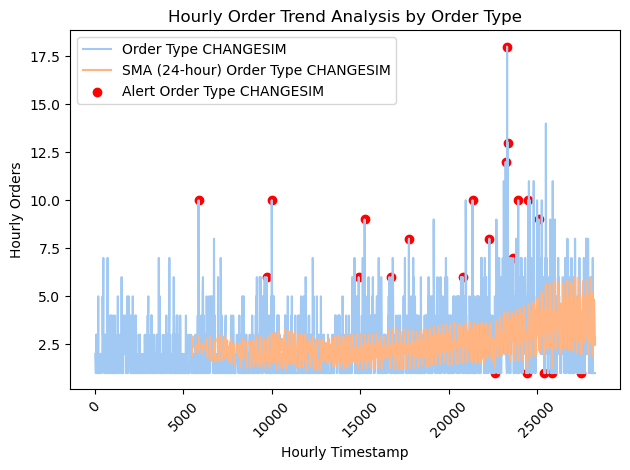

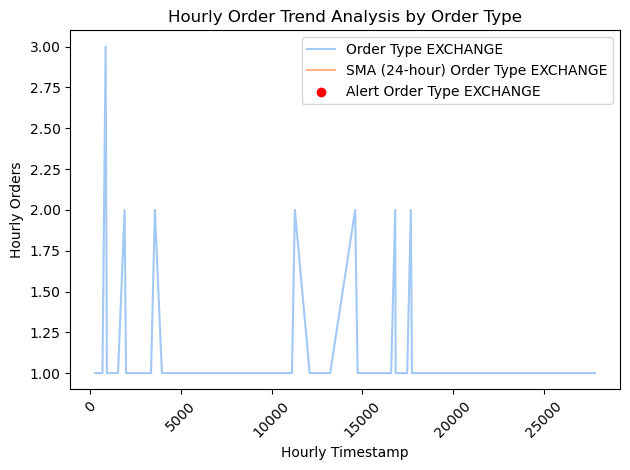

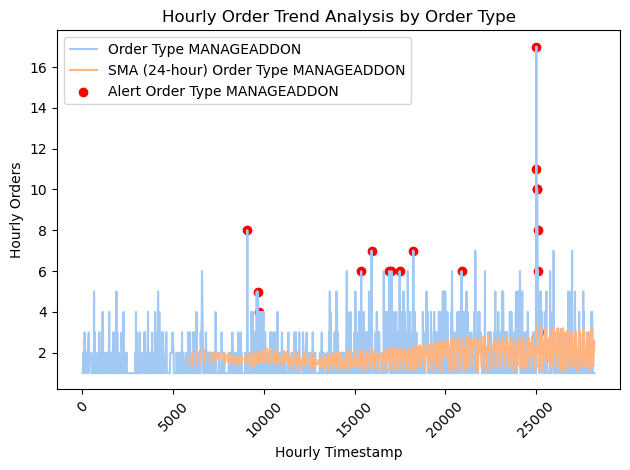

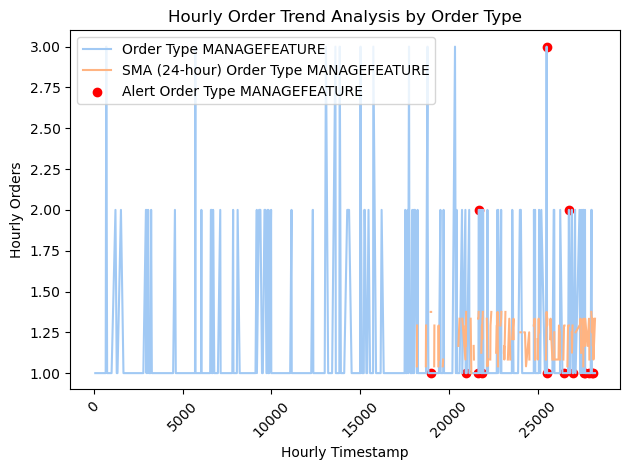

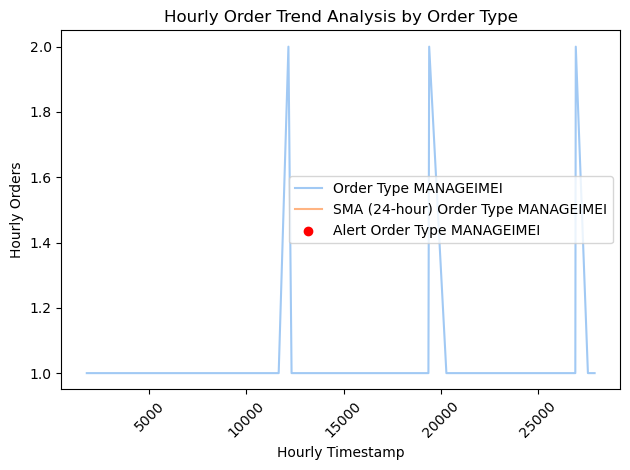

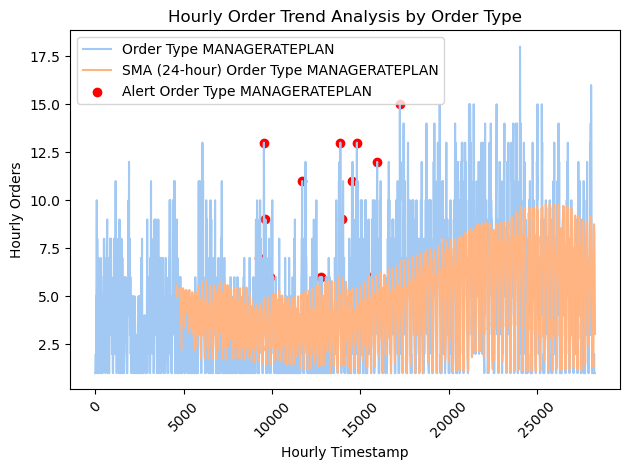

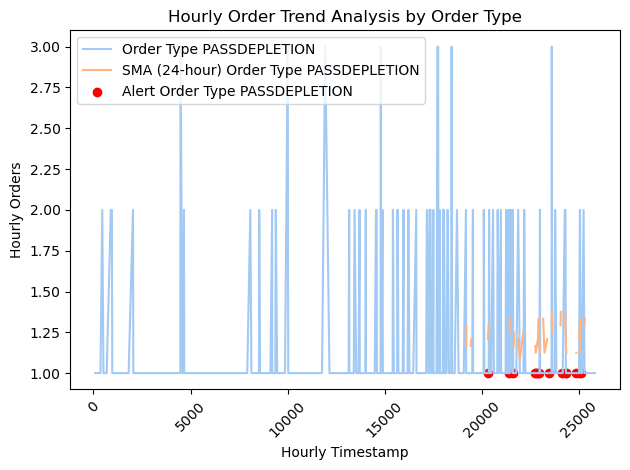

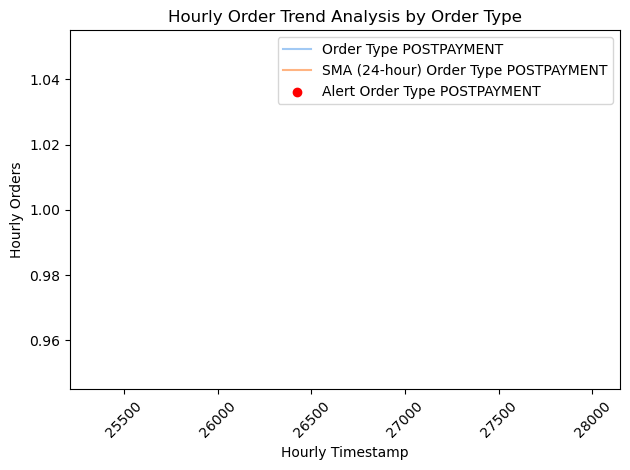

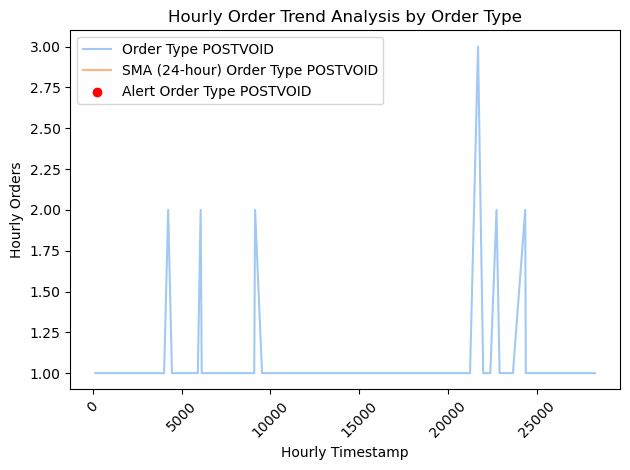

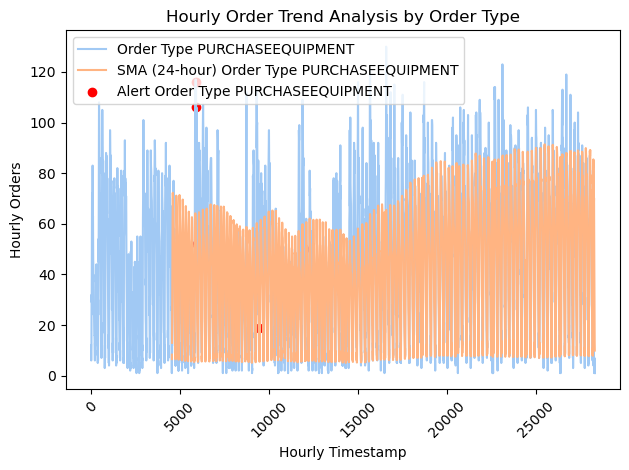

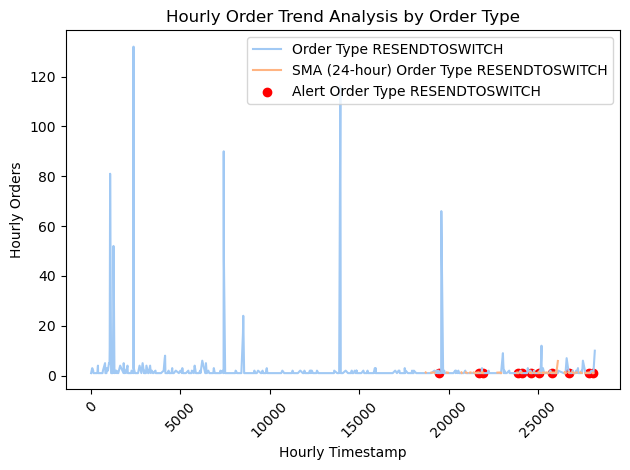

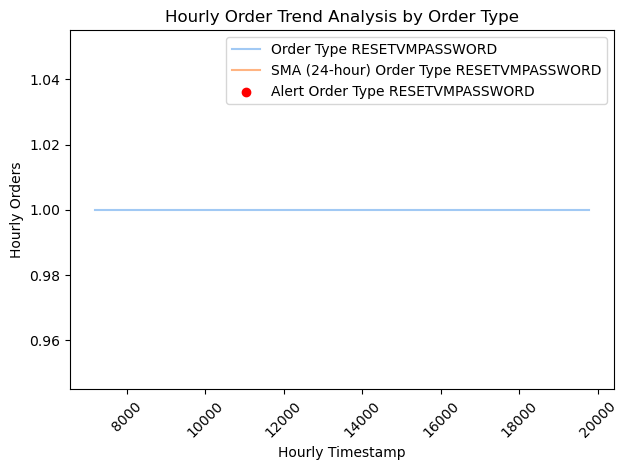

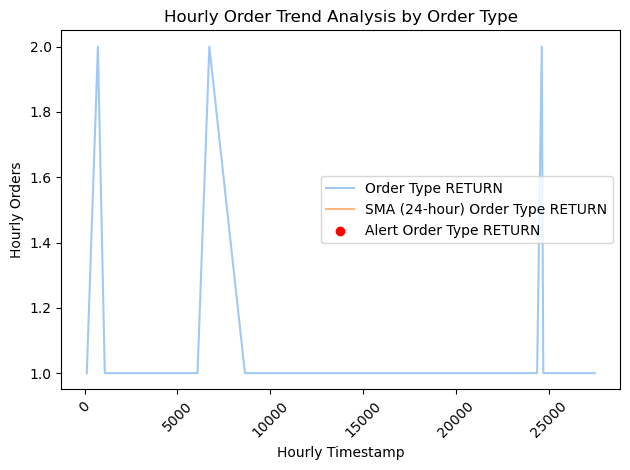

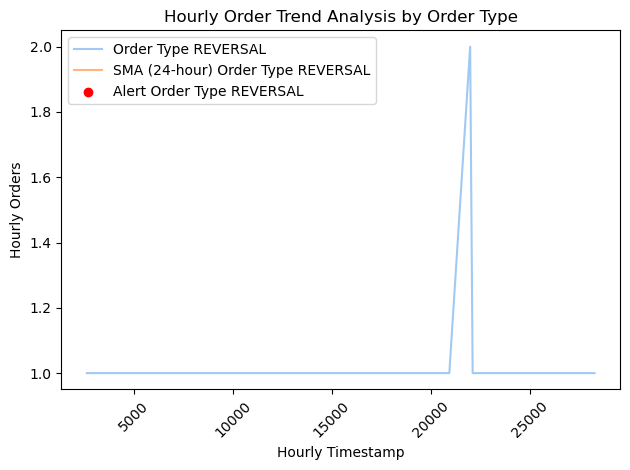

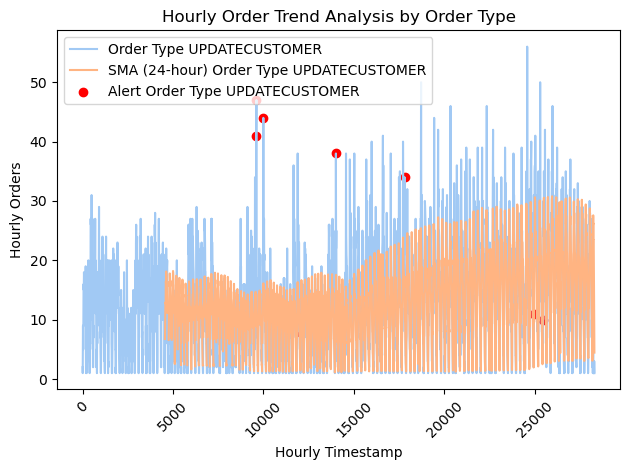

In [44]:
# Plot the alerts
plt.figure(figsize=(15, 4))
for order_type, data in hourly_counts.groupby('ORDERTYPE'):
    plt.plot(data.index, data['Count'], label=f'Order Type {order_type}')
    plt.plot(data.index, data['sma'], label=f'SMA ({window_size}-hour) Order Type {order_type}')
    alerts = data[data['Alert']]
    plt.scatter(alerts.index, alerts['Count'], color='red', marker='o', label=f'Alert Order Type {order_type}')
    plt.xlabel('Hourly Timestamp')
    plt.ylabel('Hourly Orders')
    plt.title('Hourly Order Trend Analysis by Order Type')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [45]:
# Calculate the order change for each alert
hourly_counts['OrderChange'] = hourly_counts['Count'] - hourly_counts['sma']


In [46]:
# Select rows where alerts are triggered
alerts = hourly_counts[hourly_counts['Alert']]

In [47]:
# Create a dictionary to store the number of order changes for each alert
alert_changes = {}


In [48]:
# Iterate through the alerts and calculate the number of order changes for each one
for index, row in alerts.iterrows():
    alert_time = index
    order_change = row['OrderChange']
    alert_changes[(row['Hour'], row['ORDERTYPE'])] = order_change


In [49]:
# Print the number of order changes for each alert
for (hour, order_type), order_change in alert_changes.items():
    print(f"Alert Time: {hour}, Order Type: {order_type}, Order Change: {order_change}")

Alert Time: 9, Order Type: CHANGESIM, Order Change: 7.833333333333334
Alert Time: 12, Order Type: PURCHASEEQUIPMENT, Order Change: 62.083333333333336
Alert Time: 13, Order Type: ADDONREDEEM, Order Change: 6.375
Alert Time: 14, Order Type: ADDONREDEEM, Order Change: 5.5
Alert Time: 14, Order Type: CHANGESERVICESTATUS, Order Change: 8.75
Alert Time: 14, Order Type: PURCHASEEQUIPMENT, Order Change: 60.541666666666664
Alert Time: 18, Order Type: PURCHASEEQUIPMENT, Order Change: 28.791666666666668
Alert Time: 10, Order Type: APPLYADJUSTMENTS, Order Change: 6.5
Alert Time: 20, Order Type: CHANGEMSISDN, Order Change: 17.791666666666664
Alert Time: 0, Order Type: UPDATECUSTOMER, Order Change: 12.833333333333334
Alert Time: 4, Order Type: CHANGEMSISDN, Order Change: 15.666666666666666
Alert Time: 15, Order Type: ADDONREDEEM, Order Change: 3.7916666666666665
Alert Time: 8, Order Type: CHANGESERVICESTATUS, Order Change: 23.833333333333332
Alert Time: 16, Order Type: CHANGESERVICESTATUS, Order Cha

# Anomaly detection

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

window_size = 24
hourly_counts['sma'] = hourly_counts.groupby(['Hour', 'ORDERTYPE'])['Count'].transform(lambda x: x.rolling(window=window_size).mean())


In [51]:
# Calculate the Z-Score for each data point
hourly_counts['Z-Score'] = (hourly_counts['Count'] - hourly_counts['sma']) / hourly_counts.groupby(['Hour', 'ORDERTYPE'])['Count'].transform('std')


In [52]:
# Set the threshold for anomaly detection 
threshold = 2.1

In [53]:
# Identify anomalies based on the threshold
hourly_counts['Anomaly'] = np.abs(hourly_counts['Z-Score']) > threshold

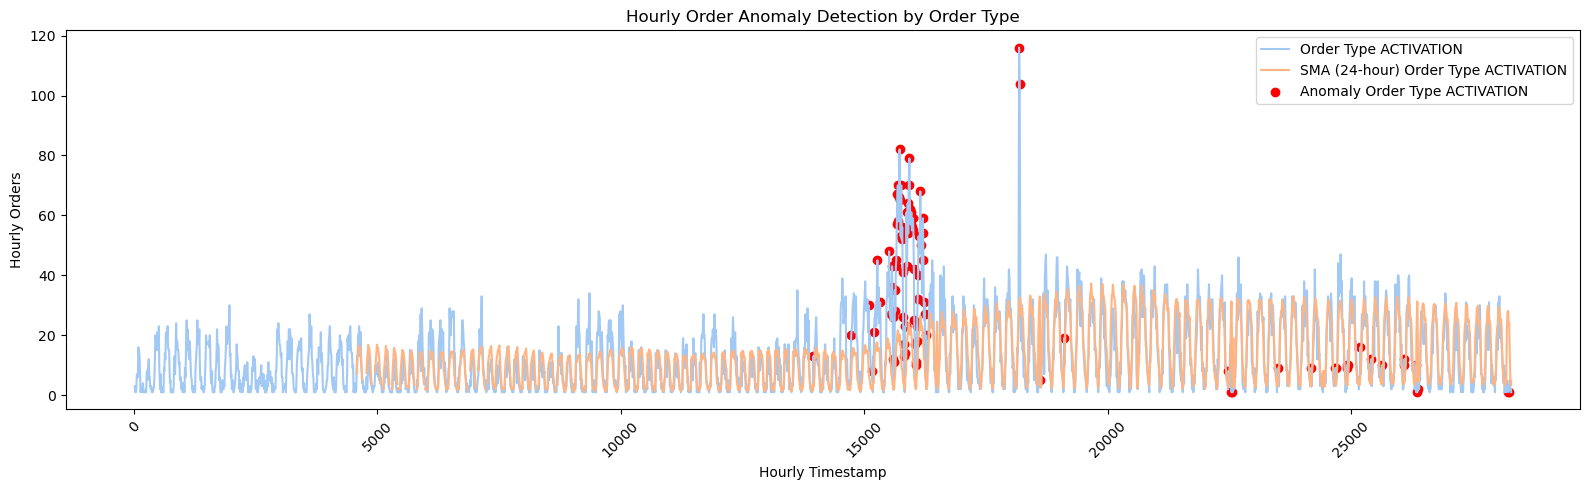

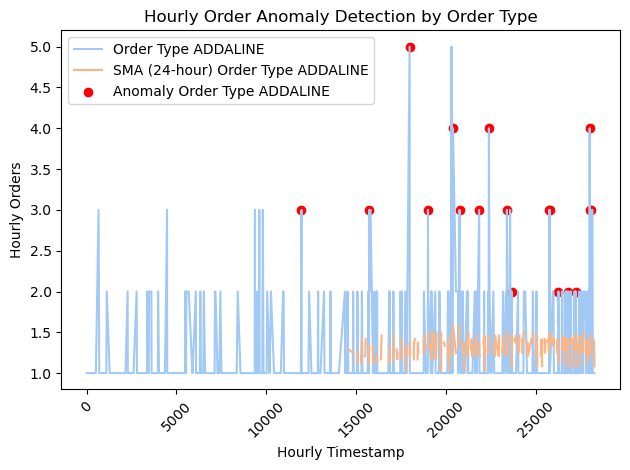

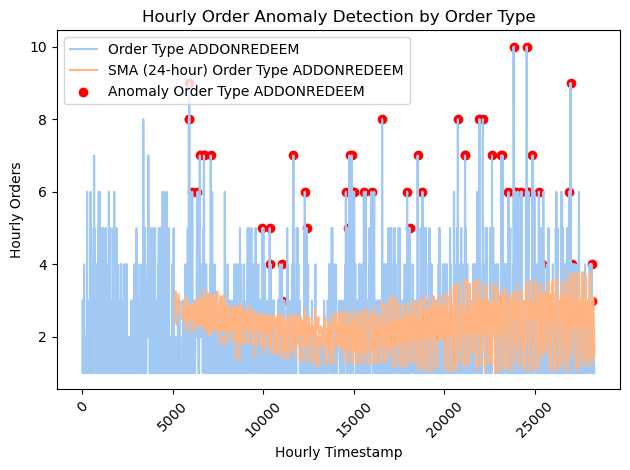

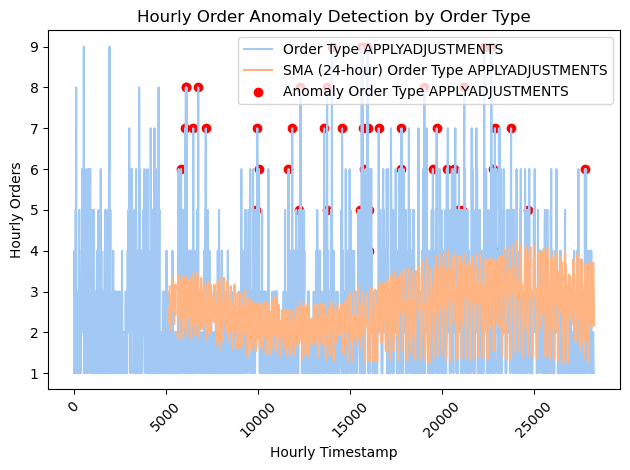

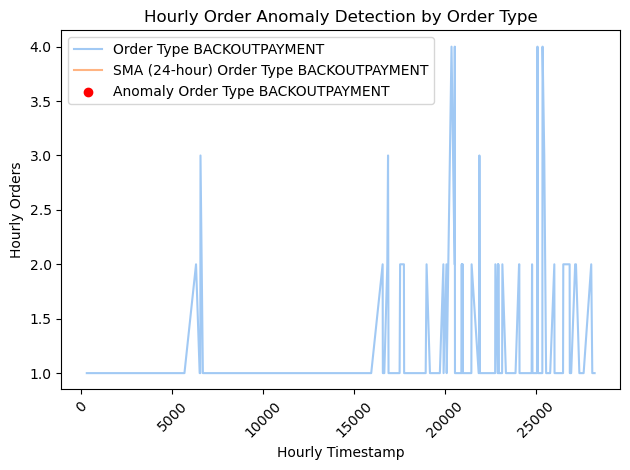

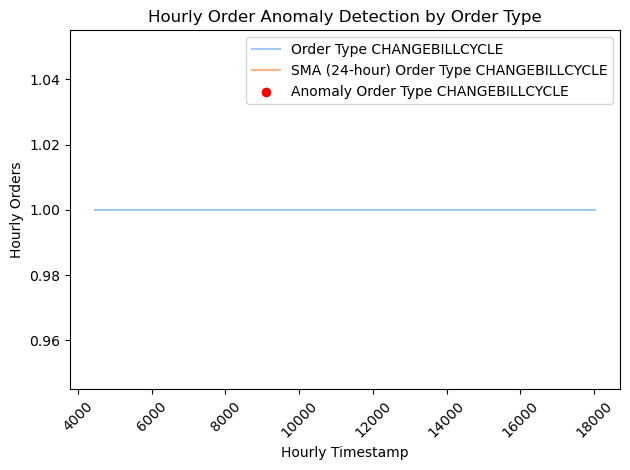

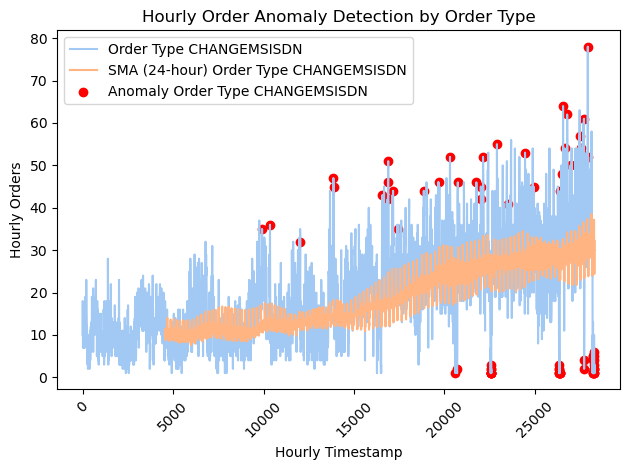

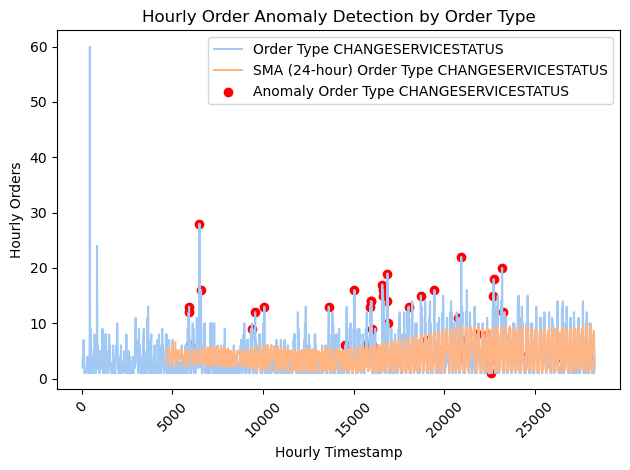

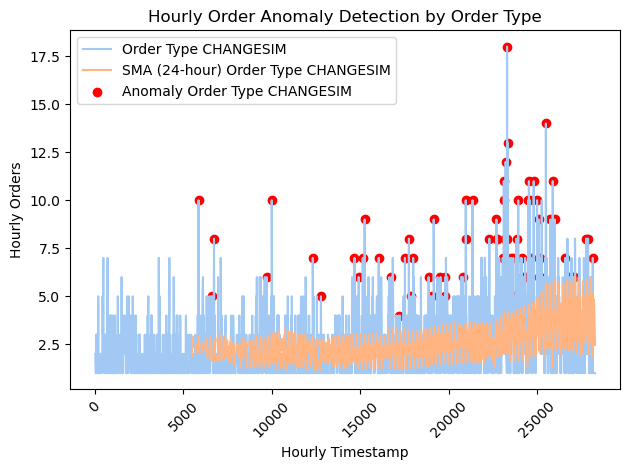

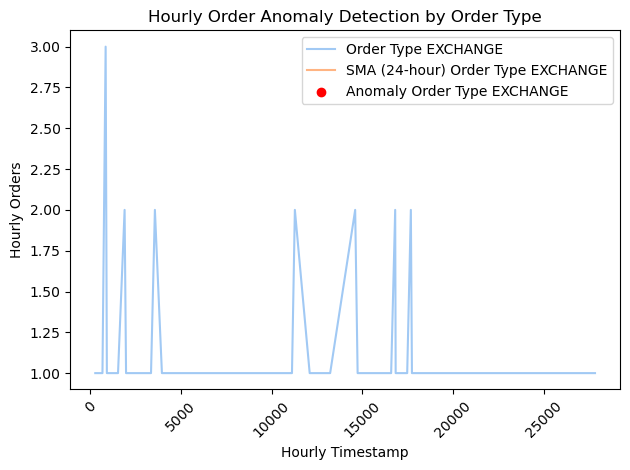

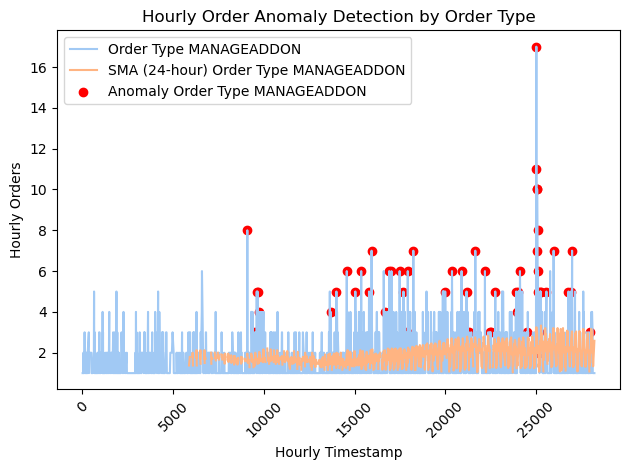

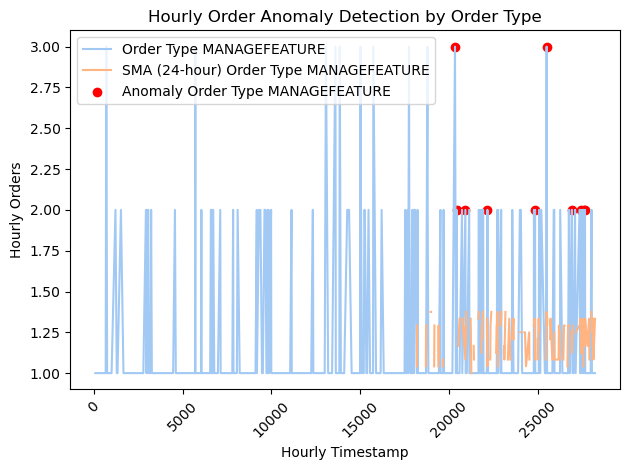

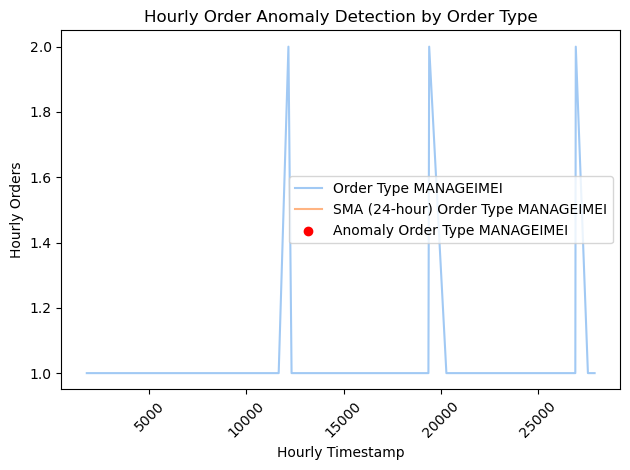

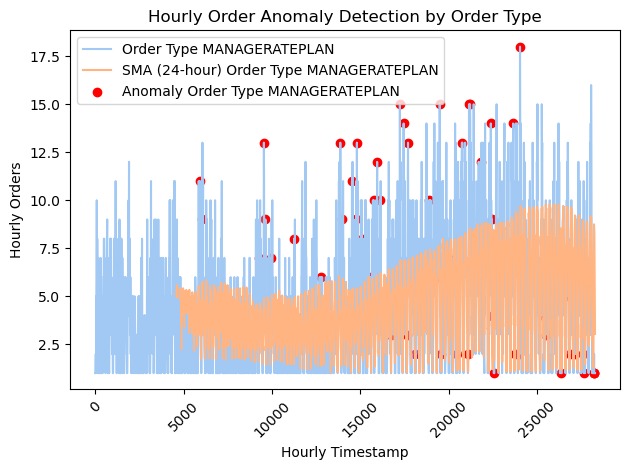

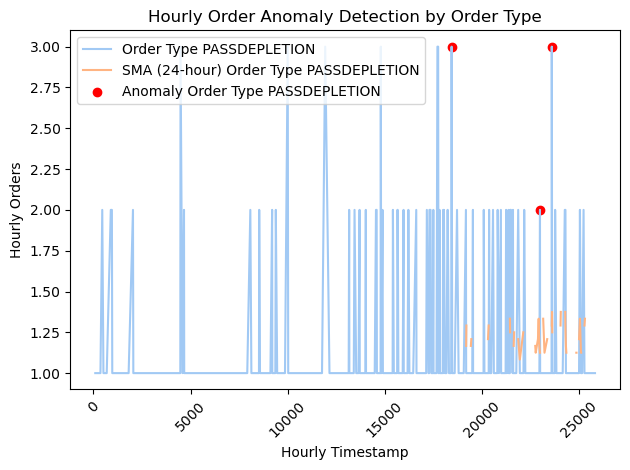

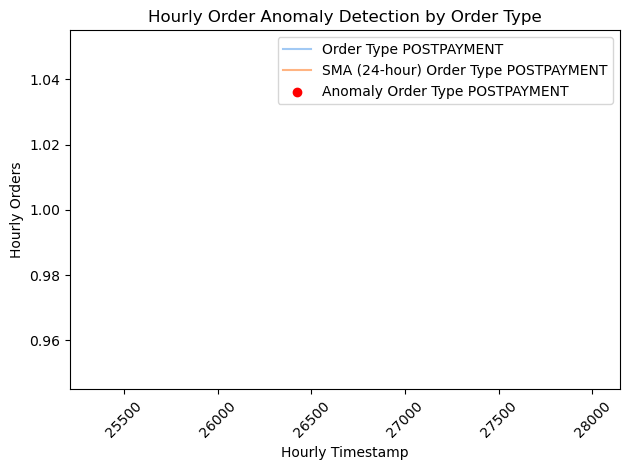

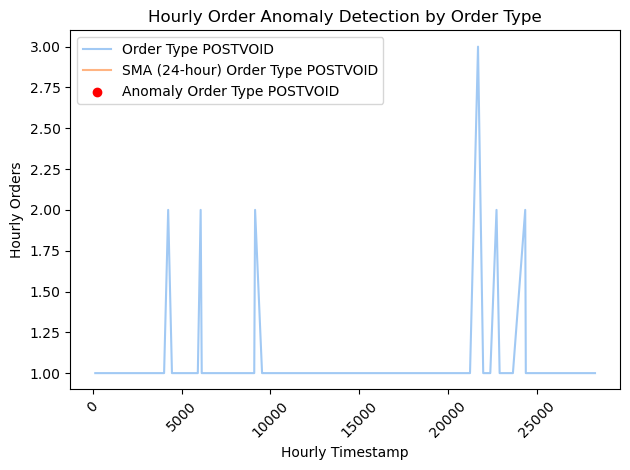

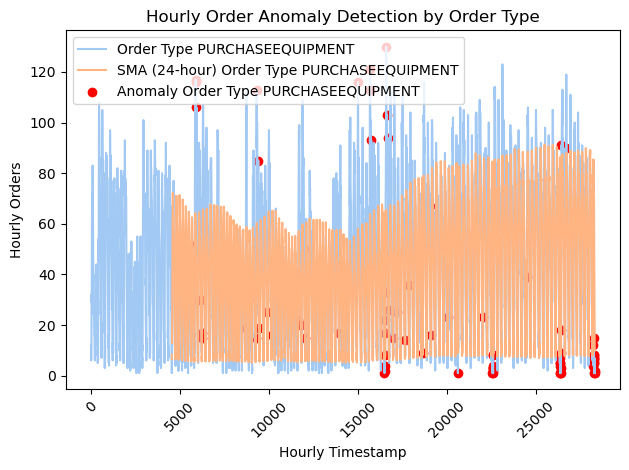

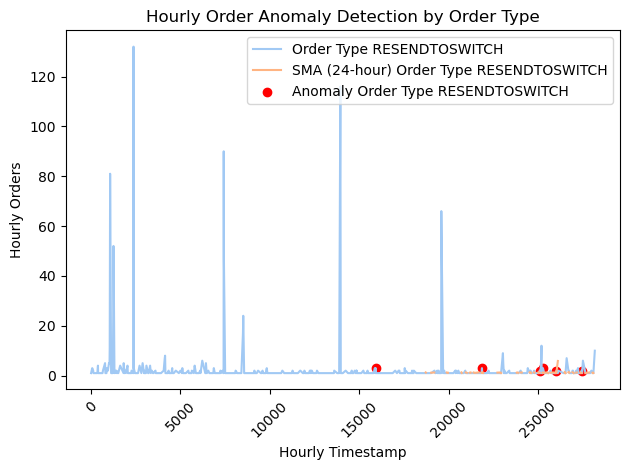

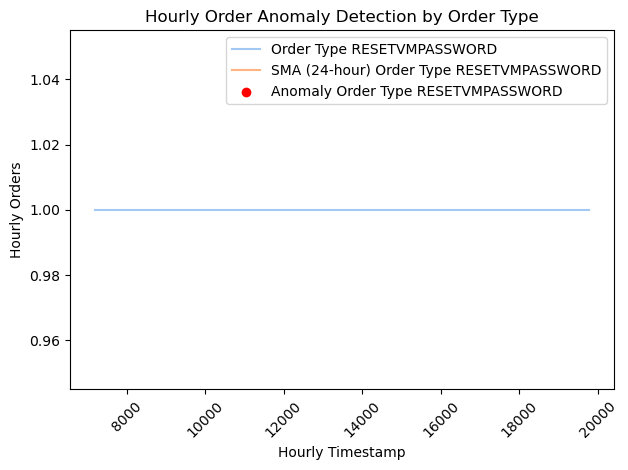

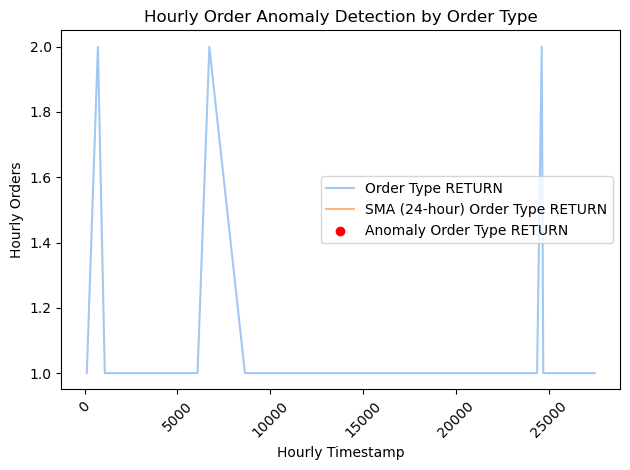

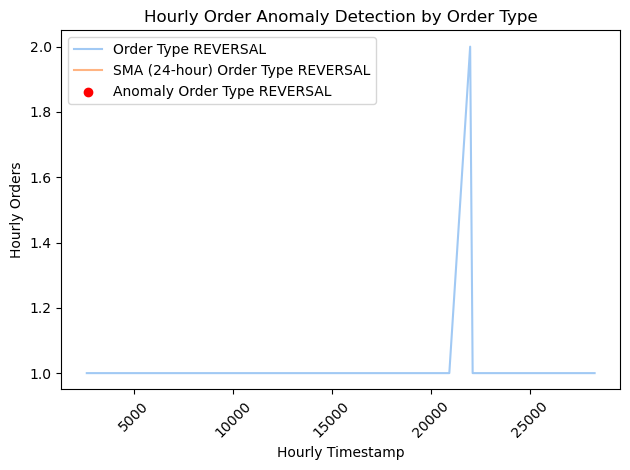

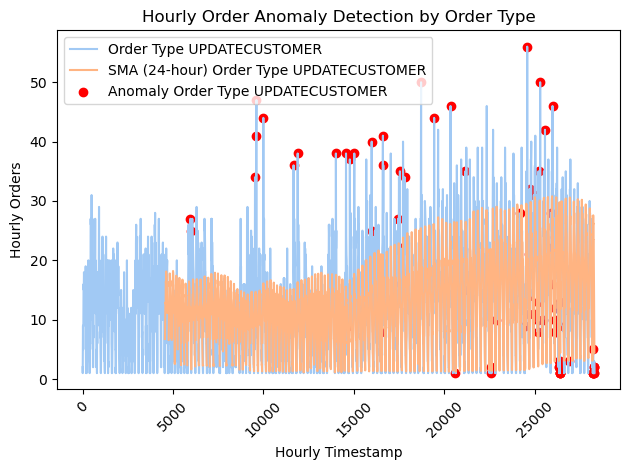

In [54]:
# Plot the anomalies
plt.figure(figsize=(16, 5))
for order_type, data in hourly_counts.groupby('ORDERTYPE'):
    plt.plot(data.index, data['Count'], label=f'Order Type {order_type}')
    plt.plot(data.index, data['sma'], label=f'SMA ({window_size}-hour) Order Type {order_type}')
    anomalies = data[data['Anomaly']]
    plt.scatter(anomalies.index, anomalies['Count'], color='red', marker='o', label=f'Anomaly Order Type {order_type}')
    plt.xlabel('Hourly Timestamp')
    plt.ylabel('Hourly Orders')
    plt.title('Hourly Order Anomaly Detection by Order Type')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [55]:
# Identify and print the anomalies
anomalies = hourly_counts[hourly_counts['Anomaly']]
for index, row in anomalies.iterrows():
    hour, order_type = row['Hour'], row['ORDERTYPE']
    anomaly_value = row['Count']
    print(f"Anomaly Detected - Hour: {hour}, Order Type: {order_type}, Value: {anomaly_value}")


Anomaly Detected - Hour: 5, Order Type: APPLYADJUSTMENTS, Value: 6
Anomaly Detected - Hour: 9, Order Type: CHANGESIM, Value: 10
Anomaly Detected - Hour: 10, Order Type: PURCHASEEQUIPMENT, Value: 117
Anomaly Detected - Hour: 11, Order Type: ADDONREDEEM, Value: 8
Anomaly Detected - Hour: 12, Order Type: CHANGESERVICESTATUS, Value: 12
Anomaly Detected - Hour: 12, Order Type: PURCHASEEQUIPMENT, Value: 116
Anomaly Detected - Hour: 13, Order Type: ADDONREDEEM, Value: 9
Anomaly Detected - Hour: 14, Order Type: ADDONREDEEM, Value: 8
Anomaly Detected - Hour: 14, Order Type: CHANGESERVICESTATUS, Value: 13
Anomaly Detected - Hour: 14, Order Type: PURCHASEEQUIPMENT, Value: 106
Anomaly Detected - Hour: 15, Order Type: MANAGERATEPLAN, Value: 11
Anomaly Detected - Hour: 18, Order Type: CHANGESERVICESTATUS, Value: 6
Anomaly Detected - Hour: 18, Order Type: PURCHASEEQUIPMENT, Value: 52
Anomaly Detected - Hour: 18, Order Type: UPDATECUSTOMER, Value: 27
Anomaly Detected - Hour: 19, Order Type: UPDATECUST

# using Prophet 

# LSTM

# RAISING ALERTS BASED ON DEVIATIONS

In [56]:
alerts = hourly_counts[hourly_counts['Alert']]
print(alerts)

             Date  Hour            ORDERTYPE  Count  Count_diff        sma  \
5862   2022-03-01     9            CHANGESIM     10         5.0   2.166667   
5896   2022-03-01    12    PURCHASEEQUIPMENT    116       107.0  53.916667   
5900   2022-03-01    13          ADDONREDEEM      9         8.0   2.625000   
5910   2022-03-01    14          ADDONREDEEM      8       -21.0   2.875000   
5913   2022-03-01    14  CHANGESERVICESTATUS     13       -12.0   4.250000   
...           ...   ...                  ...    ...         ...        ...   
27883  2022-12-07    17        MANAGEFEATURE      1         0.0   1.333333   
28056  2022-12-08    12        MANAGEFEATURE      1        -3.0   1.291667   
28093  2022-12-08    15       RESENDTOSWITCH      1       -61.0   1.250000   
28112  2022-12-08    17        MANAGEFEATURE      1        -3.0   1.333333   
28267  2022-12-09    18             ADDALINE      1        -1.0   1.083333   

       Percentage_change  Alert  OrderChange   Z-Score  Anomaly

# CONNECTING TO A SMTP SERVER TO SEND EMAIL NOTIFICATION

In [57]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import pandas as pd

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import logging

def send_email(subject, message):
    sender_email = "damboledheeraj@gmail.com"  
    receiver_email = "aadibansal176@gmail.com"  
    password = "znbf pdav ioox edzo" 
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = 'Alerts Report'

    column_data_str = alerts.to_string(index=False)

    email_body = f"{column_data_str}\n\n{message}"
    msg.attach(MIMEText(email_body, 'plain'))
    
    try:
        server = smtplib.SMTP("smtp.gmail.com", 587) 
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        logging.info(f"Email notification sent to {receiver_email}: {subject}")
    except Exception as e:
        logging.error(f"Failed to send email notification: {str(e)}")

if threshold >= 0.4:
    logging.warning('Alert: Standard number of orders has changed.')
    custom_message = "Standard number of orders has changed. Check the trend analyzer for detail. https://shorturl.at/bnryP"
    send_email(custom_message,"Order Alert")

# RUNNING OUR DATA FETCHING AND EMAIL NOTIFICATION PROGRAMS AT REGULAR TIME INTERVALS TO WORK ON REAL TIME DATA 

In [ ]:
import schedule
import time

def my_task():
    def send_email(subject, message):
        sender_email = "damboledheeraj@gmail.com"  # Your email address
        receiver_email = "mittaldevansh48@gmail.com"  # Recipient's email address
        password = "znbf pdav ioox edzo" 
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = receiver_email
        msg['Subject'] = 'Alerts Report'

        column_data_str = alerts.to_string(index=False)

        email_body = f"{column_data_str}\n\n{message}"
        msg.attach(MIMEText(email_body, 'plain'))

        try:
            server = smtplib.SMTP("smtp.gmail.com", 587) 
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            server.quit()
            logging.info(f"Email notification sent to {receiver_email}: {subject}")
        except Exception as e:
            logging.error(f"Failed to send email notification: {str(e)}")

    if threshold >= 0.4:
        logging.warning('Alert: Standard number of orders has changed.')
        custom_message = "Standard number of orders has changed. Check the trend analyzer for detail. https://shorturl.at/bnryP"
        send_email(custom_message,"Order Alert")
        print("ANALYSER WILL CHECK AGAIN IN 10 MINUTES")

schedule.every(10).minutes.do(my_task)

# Run the scheduler
while True:
    schedule.run_pending()
    time.sleep(1)  # Sleep for 1 second to avoid high CPU usage